# Context of the notebook 
Here, we're using training and test sets which have been stored in parquet files in the *training_data* and *test_data* folders. 
Tasks perfomed:
- 3 datasets are created based on clustered complexes (sequence clustering has been performed using CD-Hit). 
- feature engineering is performed on the 3 datasets 
- final datasets are created by joining protein and ligand datasets 
- baseline algorithm is set 

In [1]:
# Basic python libraries
import os 
import patoolib
from glob import glob 
from multiprocessing.pool import Pool
import warnings
import struct
import pickle
warnings.filterwarnings('ignore')

# Biological libraries 
from biopandas.pdb import PandasPdb
from biopandas.mol2 import PandasMol2
import mol2vec
import prot2vec

# Regular DS libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

# AI libraries 
import sklearn 

# Refined set - Training data

In [19]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/training_data/original_datasets/binding_constants_train.parquet"
binding_constants_train = pd.read_parquet(path)

In [20]:
binding_constants_train = binding_constants_train.sort_values(by='pdb_code',axis=0,ascending=True)

In [21]:
"""
    Download the dataframe from the .parquet file 
                                                    """ 
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/training_data/original_datasets/df_proteins.parquet"
df_proteins = pd.read_parquet(path)

In [22]:
path = path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/training_data/original_datasets/df_ligands_atoms.parquet"
df_ligands_atoms = pd.read_parquet(path)

In [23]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/training_data/original_datasets/df_ligands_bonds.parquet"
df_ligands_bonds = pd.read_parquet(path)

In [24]:
df_ligands_bonds

,pdb_code,bond_id,origin_atom_id,target_atom_id,bond_type
0,10gs,1,2,1,1
1,10gs,2,2,5,1
2,10gs,3,2,3,1
3,10gs,4,3,4,ar
4,10gs,5,3,9,ar
...,...,...,...,...,...
264674,966c,46,24,44,1
264675,966c,47,26,45,1
264676,966c,48,26,46,1
264677,966c,49,27,47,1


# CASF-2016 coreset - Testing data

In [25]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/test_data/binding_constants_test.parquet"
binding_constants_test = pd.read_parquet(path)
binding_constants_test = binding_constants_test.rename(columns={'#code':'pdb_code','logKa':'pKd_or_pKi','Ka':'Kd_or_Ki'})

In [26]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/test_data/df_proteins_test.parquet"
df_proteins_test = pd.read_parquet(path)

In [27]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/test_data/df_ligands_atoms_test.parquet"
df_ligands_atoms_test = pd.read_parquet(path)

In [28]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/test_data/df_ligands_bonds_test.parquet"
df_ligands_bonds_test = pd.read_parquet(path)

#### Remove the 263 common complexes between the train and test from the train set 

In [29]:
""" 
    Remove the 263 comon complexes from the training set to make sure there is no data leakage 
                                                                                                """
comon_complex_values = binding_constants_train.merge(binding_constants_test,how='inner',on='pdb_code').pdb_code.values

binding_constants_train = binding_constants_train[binding_constants_train.pdb_code.isin(comon_complex_values) == False]
df_proteins = df_proteins[df_proteins.pdb_code.isin(comon_complex_values) == False]
df_ligands_atoms = df_ligands_atoms[df_ligands_atoms.pdb_code.isin(comon_complex_values) == False]
df_ligands_bonds = df_ligands_bonds[df_ligands_bonds.pdb_code.isin(comon_complex_values) == False]

#### Sequence Clustering 
Sequence clustering has been performed based on the similarity of the protein sequences using CD-HIT (1591 clusters were generated)

In [30]:
"""
After removing duplicate complexes within the different clusters, we have 1394 clusters at the end. 
From this, we can build 3 different datasets wich will be used for AI purposes.
                                                                                                    """
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Sequence_clustering/PDBbind_v2020_refined/"
seq_clustering = pd.read_excel(os.path.join(path,'dataset.xlsx'))
seq_clustering.drop(['Unnamed: 5','Unnamed: 6'],inplace=True,axis=1)
seq_clustering

,clusters_num,pdb_code,similarity_rate,Kd_or_Ki,pKd_or_pKi
0,cluster_0,4qgi,93.94%,125uM,3.90
1,cluster_0,1a30,96.97%,50uM,4.30
2,cluster_0,2avq,93.94%,41uM,4.39
3,cluster_0,1aid,94.95%,15uM,4.82
4,cluster_0,2aoc,93.94%,13.0uM,4.89
...,...,...,...,...,...
4888,cluster_1506,6fhu,NaN,2.3mM,2.64
4889,cluster_1507,6mj7,NaN,1.5mM,2.82
4890,cluster_1508,5vh0,NaN,30uM,4.52
4891,cluster_1509,6a87,NaN,0.7mM,3.15


# Dataset 1 
### Taking the pdb codes to build dataset_1 with min, max and median binding constants 

In [31]:
min_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).min()[['clusters_num','pKd_or_pKi']]
min_bind_const_comp = min_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [32]:
median_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).median()
median_bind_const_comp = median_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [33]:
max_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).max()[['clusters_num','pKd_or_pKi']]
max_bind_const_comp = max_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [34]:
from itertools import chain 
#Concatenate the three lists
bind_const_dataset1_comp = list(chain(min_bind_const_comp,median_bind_const_comp,max_bind_const_comp))
#Keep unique values from the result list 
bind_const_dataset1_comp = list(dict.fromkeys(bind_const_dataset1_comp))
#Check the length of the new list
print(f'The number of complexes with dataset 1 is equal to: {len(bind_const_dataset1_comp)}')

The number of complexes with dataset 1 is equal to: 2318


In [35]:
def checkIfDuplicates(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

In [36]:
checkIfDuplicates(bind_const_dataset1_comp)

False

In [37]:
binding_constants_train_dataset1 = binding_constants_train[binding_constants_train['pdb_code'].isin(bind_const_dataset1_comp)]

In [38]:
df_proteins_dataset1 = df_proteins[df_proteins['pdb_code'].isin(bind_const_dataset1_comp)]

In [39]:
df_ligands_atoms_dataset1 = df_ligands_atoms[df_ligands_atoms['pdb_code'].isin(bind_const_dataset1_comp)]

In [40]:
df_ligands_bonds_dataset1 = df_ligands_bonds[df_ligands_bonds['pdb_code'].isin(bind_const_dataset1_comp)]

In [41]:
"""
    In the dataset 1 (bind_const_dataset1_comp), there are 2318 complexes. 
    Afterwards, the different dataframes have only 2252 complexes, hence a difference of 66 complexes.
    Here, we're checking we actually have 66 complexes as a difference
                                                                                                        """
out_list = []
for element in bind_const_dataset1_comp:
    if element not in binding_constants_train_dataset1.pdb_code.values:
        out_list.append(element)
print(len(out_list))

66


In [42]:
"""
    Here, we're checking where did we loose these 66 complexes, if it was a mistake or not. 
    Here, we show that those 66 complexes are not present in the resulting dataframes because they have been 
    deleted beforehand as they were common to the test set.
                                                                                                                """ 
in_list = []
for element in out_list:
    if element in comon_complex_values:
        in_list.append(element)
print(f'Here, we show that these {len(in_list)} complexes are present in the deleted comon complexes between the train and test')

Here, we show that these 66 complexes are present in the deleted comon complexes between the train and test


In [43]:
"""
    Here, we're checking where did we loose these 74 complexes, if it was a mistake or not. 
    Here, we show that those 74 complexes are not present in the resulting dataframes because they have been 
    deleted beforehand as they were common to the test set.
                                                                                                                """ 
in_list = []
for element in out_list:
    if element in comon_complex_values:
        in_list.append(element)
print(f'Here, we show that these {len(in_list)} complexes are present in the deleted comon complexes between the train and test')

Here, we show that these 66 complexes are present in the deleted comon complexes between the train and test


# Dataset 2

### Taking the pdb codes to build dataset_2 by taking min, 20 centile, median, 80th centile and maximum binding constants

In [44]:
min_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).min()[['clusters_num','pKd_or_pKi']]
min_bind_const_comp = min_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [45]:
twentieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.20)
twentieth_percentile_const_comp = twentieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [46]:
median_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).median()[['clusters_num','pKd_or_pKi']]
median_bind_const_comp = median_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [47]:
eightieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.80)
eightieth_percentile_const_comp = eightieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [48]:
max_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).max()[['clusters_num','pKd_or_pKi']]
max_bind_const_comp = max_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [49]:
from itertools import chain 
#Concatenate the three lists
bind_const_dataset2_comp = list(chain(min_bind_const_comp,twentieth_percentile_const_comp,median_bind_const_comp, 
                                eightieth_percentile_const_comp,max_bind_const_comp))
#Keep unique values from the result list 
bind_const_dataset2_comp = list(dict.fromkeys(bind_const_dataset2_comp))
#Check the length of the new list
print(f'The number of complexes with dataset 2 is equal to: {len(bind_const_dataset2_comp)}')

The number of complexes with dataset 2 is equal to: 2443


In [50]:
checkIfDuplicates(bind_const_dataset2_comp)

False

In [51]:
binding_constants_train_dataset2 = binding_constants_train[binding_constants_train['pdb_code'].isin(bind_const_dataset2_comp)]

In [52]:
df_proteins_dataset2 = df_proteins[df_proteins['pdb_code'].isin(bind_const_dataset2_comp)]

In [53]:
df_ligands_atoms_dataset2 = df_ligands_atoms[df_ligands_atoms['pdb_code'].isin(bind_const_dataset2_comp)]

In [54]:
df_ligands_bonds_dataset2 = df_ligands_bonds[df_ligands_bonds['pdb_code'].isin(bind_const_dataset2_comp)]

In [55]:
"""
    In the dataset 2 (bind_const_dataset2_comp), there are 2636 complexes. 
    Afterwards, the different dataframes have only 2552 complexes, hence a difference of 84 complexes.
    Here, we're checking we actually have 84 complexes as a difference
                                                                                                        """
out_list = []
for element in bind_const_dataset2_comp:
    if element not in binding_constants_train_dataset2.pdb_code.values:
        out_list.append(element)
print(len(out_list))

69


In [56]:
"""
    Here, we're checking where did we loose these 74 complexes, if it was a mistake or not. 
    Here, we show that those 74 complexes are not present in the resulting dataframes because they have been 
    deleted beforehand as they were common to the test set.
                                                                                                                """ 
in_list = []
for element in out_list:
    if element in comon_complex_values:
        in_list.append(element)
print(f'Here, we show that these {len(in_list)} complexes are present in the deleted comon complexes between the train and test')

Here, we show that these 69 complexes are present in the deleted comon complexes between the train and test


# Dataset 3
### Taking the pdb codes to build dataset_3 with min, 25th centile, median, 75th centile and max binding constants 

In [57]:
min_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).min()[['clusters_num','pKd_or_pKi']]
min_bind_const_comp = min_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [58]:
twentyfifth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.25)
twentyfifth_percentile_const_comp = twentyfifth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [59]:
median_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).median()
median_bind_const_comp = median_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [60]:
seventyfifth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.75)
seventyfifth_percentile_const_comp = seventyfifth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [61]:
max_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).max()[['clusters_num','pKd_or_pKi']]
max_bind_const_comp = max_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [62]:
from itertools import chain 
#Concatenate the three lists
bind_const_dataset3_comp = list(chain(min_bind_const_comp,twentyfifth_percentile_const_comp,median_bind_const_comp,seventyfifth_percentile_const_comp,max_bind_const_comp))
#Keep unique values from the result list 
bind_const_dataset3_comp = list(dict.fromkeys(bind_const_dataset3_comp))
#Check the length of the new list
print(f'The number of complexes with dataset 3 is equal to: {len(bind_const_dataset3_comp)}')

The number of complexes with dataset 3 is equal to: 2495


In [63]:
checkIfDuplicates(bind_const_dataset3_comp)

False

In [64]:
binding_constants_train_dataset3 = binding_constants_train[binding_constants_train['pdb_code'].isin(bind_const_dataset3_comp)]

In [65]:
df_proteins_dataset3 = df_proteins[df_proteins['pdb_code'].isin(bind_const_dataset3_comp)]

In [66]:
df_ligands_atoms_dataset3 = df_ligands_atoms[df_ligands_atoms['pdb_code'].isin(bind_const_dataset3_comp)]

In [67]:
df_ligands_bonds_dataset3 = df_ligands_bonds[df_ligands_bonds['pdb_code'].isin(bind_const_dataset3_comp)]

In [68]:
"""
    In the dataset 3 (bind_const_dataset3_comp), there are 2416 complexes. 
    Afterwards, the different dataframes have only 2342 complexes, hence a difference of 66 complexes.
    Here, we're checking we actually have 66 complexes as a difference
                                                                                                        """
out_list = []
for element in bind_const_dataset3_comp:
    if element not in binding_constants_train_dataset3.pdb_code.values:
        out_list.append(element)
print(len(out_list))

74


In [69]:
"""
    Here, we're checking where did we loose these 74 complexes, if it was a mistake or not. 
    Here, we show that those 74 complexes are not present in the resulting dataframes because they have been 
    deleted beforehand as they were common to the test set.
                                                                                                                """ 
in_list = []
for element in out_list:
    if element in comon_complex_values:
        in_list.append(element)
print(f'Here, we show that these {len(in_list)} complexes are present in the deleted comon complexes between the train and test')

Here, we show that these 74 complexes are present in the deleted comon complexes between the train and test


# Feature engineering 

## Feature engineering on df_lig_bonds

In [70]:
"""
    Here, the purpose is to count the number of bond types each ligand has. 
    We want to prepare aggregated df at the complex granularity.
                                                                            """
# Dataset 1
nb_bond_types_df1 = df_ligands_bonds_dataset1.groupby(['pdb_code','bond_type']).count().reset_index()
nb_bond_types_df1 = nb_bond_types_df1[['pdb_code','bond_type','bond_id']].rename(columns={'bond_id':'lig_nb_bonds'})

# Dataset 2
nb_bond_types_df2 = df_ligands_bonds_dataset2.groupby(['pdb_code','bond_type']).count().reset_index()
nb_bond_types_df2 = nb_bond_types_df2[['pdb_code','bond_type','bond_id']].rename(columns={'bond_id':'lig_nb_bonds'})

# Dataset 3
nb_bond_types_df3 = df_ligands_bonds_dataset3.groupby(['pdb_code','bond_type']).count().reset_index()
nb_bond_types_df3 = nb_bond_types_df3[['pdb_code','bond_type','bond_id']].rename(columns={'bond_id':'lig_nb_bonds'})

# Test
nb_bond_types_test = df_ligands_bonds_test.groupby(['pdb_code','bond_type']).count().reset_index()
nb_bond_types_test = nb_bond_types_test[['pdb_code','bond_type','bond_id']].rename(columns={'bond_id':'lig_nb_bonds'})

In [71]:
"""
    Here, the purpose is to calculate the average number of bonds each ligand has. 
    We want to prepare aggregated df at the complex granularity.
                                                                                    """
# Dataset 1
mean_bond_types_df1 = df_ligands_bonds_dataset1.groupby(['pdb_code','bond_type']).count()['bond_id'] / df_ligands_bonds_dataset1.groupby(['pdb_code']).count()['bond_id']
mean_bond_types_df1 = mean_bond_types_df1.reset_index().rename(columns={'bond_id':'lig_mean_nb_bonds'})

# Dataset 2
mean_bond_types_df2 = df_ligands_bonds_dataset2.groupby(['pdb_code','bond_type']).count()['bond_id'] / df_ligands_bonds_dataset2.groupby(['pdb_code']).count()['bond_id']
mean_bond_types_df2 = mean_bond_types_df2.reset_index().rename(columns={'bond_id':'lig_mean_nb_bonds'})

# Dataset 3
mean_bond_types_df3 = df_ligands_bonds_dataset3.groupby(['pdb_code','bond_type']).count()['bond_id'] / df_ligands_bonds_dataset3.groupby(['pdb_code']).count()['bond_id']
mean_bond_types_df3 = mean_bond_types_df3.reset_index().rename(columns={'bond_id':'lig_mean_nb_bonds'})

# Test
mean_bond_types_test = df_ligands_bonds_test.groupby(['pdb_code','bond_type']).count()['bond_id'] / df_ligands_bonds_test.groupby(['pdb_code']).count()['bond_id']
mean_bond_types_test = mean_bond_types_test.reset_index().rename(columns={'bond_id':'lig_mean_nb_bonds'})

In [72]:
# Dataset 1
""" Here, we're joining the dataframes """  
bonds_df_dataset1 = nb_bond_types_df1.merge(mean_bond_types_df1,how='inner',on=['pdb_code','bond_type']) #join df 

""" Here, we're creationg a new feature """
bonds_df_dataset1['lig_nb_mean_diff'] = bonds_df_dataset1['lig_nb_bonds'] - bonds_df_dataset1['lig_mean_nb_bonds'] # addition of a new column which substracts nb and mean 

# Dataset 2
""" Here, we're joining the dataframes """  
bonds_df_dataset2 = nb_bond_types_df2.merge(mean_bond_types_df2,how='inner',on=['pdb_code','bond_type']) #join simple bonds df 

""" Here, we're creationg a new feature """
bonds_df_dataset2['lig_nb_mean_diff'] = bonds_df_dataset2['lig_nb_bonds'] - bonds_df_dataset2['lig_mean_nb_bonds'] # addition of a new column which substracts nb and mean 

# Dataset 3
""" Here, we're joining the dataframes """  
bonds_df_dataset3 = nb_bond_types_df3.merge(mean_bond_types_df3,how='inner',on=['pdb_code','bond_type']) #join simple bonds df 

""" Here, we're creationg a new feature """
bonds_df_dataset3['lig_nb_mean_diff'] = bonds_df_dataset3['lig_nb_bonds'] - bonds_df_dataset3['lig_mean_nb_bonds'] # addition of a new column which substracts nb and mean 

# Test
""" Here, we're joining the dataframes """  
bonds_df_test = nb_bond_types_test.merge(mean_bond_types_test,how='inner',on=['pdb_code','bond_type']) #join simple bonds df 

""" Here, we're creationg a new feature """
bonds_df_test['lig_nb_mean_diff'] = bonds_df_test['lig_nb_bonds'] - bonds_df_test['lig_mean_nb_bonds'] # addition of a new column which substracts nb and mean 

In [73]:
""" Here, I'm building dfs based on the bond type at the complex granularity which will be joined later to the other df to build the final bigger dataset """ 

# Dataset 1
nb_simple_bonds_dataset1 = bonds_df_dataset1[bonds_df_dataset1['bond_type'] == '1'].rename(columns={'lig_nb_bonds':'lig_nb_simple_bonds','lig_mean_nb_bonds':'lig_mean_simple_bonds','lig_nb_mean_diff':'lig_nb_mean_simple_diff'})
nb_double_bonds_dataset1 = bonds_df_dataset1[bonds_df_dataset1['bond_type'] == '2'].rename(columns={'lig_nb_bonds':'lig_nb_double_bonds','lig_mean_nb_bonds':'lig_mean_double_bonds','lig_nb_mean_diff':'lig_nb_mean_double_diff'})
nb_triple_bonds_dataset1 = bonds_df_dataset1[bonds_df_dataset1['bond_type'] == '3'].rename(columns={'lig_nb_bonds':'lig_nb_triple_bonds','lig_mean_nb_bonds':'lig_mean_triple_bonds','lig_nb_mean_diff':'lig_nb_mean_triple_diff'})
nb_ar_bonds_dataset1 = bonds_df_dataset1[bonds_df_dataset1['bond_type'] == 'ar'].rename(columns={'lig_nb_bonds':'lig_nb_ar_bonds','lig_mean_nb_bonds':'lig_mean_ar_bonds','lig_nb_mean_diff':'lig_nb_mean_ar_diff'})
nb_am_bonds_dataset1 = bonds_df_dataset1[bonds_df_dataset1['bond_type'] == 'am'].rename(columns={'lig_nb_bonds':'lig_nb_am_bonds','lig_mean_nb_bonds':'lig_mean_am_bonds','lig_nb_mean_diff':'lig_nb_mean_am_diff'})

# Dataset 2
nb_simple_bonds_dataset2 = bonds_df_dataset2[bonds_df_dataset2['bond_type'] == '1'].rename(columns={'lig_nb_bonds':'lig_nb_simple_bonds','lig_mean_nb_bonds':'lig_mean_simple_bonds','lig_nb_mean_diff':'lig_nb_mean_simple_diff'})
nb_double_bonds_dataset2 = bonds_df_dataset2[bonds_df_dataset2['bond_type'] == '2'].rename(columns={'lig_nb_bonds':'lig_nb_double_bonds','lig_mean_nb_bonds':'lig_mean_double_bonds','lig_nb_mean_diff':'lig_nb_mean_double_diff'})
nb_triple_bonds_dataset2 = bonds_df_dataset2[bonds_df_dataset2['bond_type'] == '3'].rename(columns={'lig_nb_bonds':'lig_nb_triple_bonds','lig_mean_nb_bonds':'lig_mean_triple_bonds','lig_nb_mean_diff':'lig_nb_mean_triple_diff'})
nb_ar_bonds_dataset2 = bonds_df_dataset2[bonds_df_dataset2['bond_type'] == 'ar'].rename(columns={'lig_nb_bonds':'lig_nb_ar_bonds','lig_mean_nb_bonds':'lig_mean_ar_bonds','lig_nb_mean_diff':'lig_nb_mean_ar_diff'})
nb_am_bonds_dataset2 = bonds_df_dataset2[bonds_df_dataset2['bond_type'] == 'am'].rename(columns={'lig_nb_bonds':'lig_nb_am_bonds','lig_mean_nb_bonds':'lig_mean_am_bonds','lig_nb_mean_diff':'lig_nb_mean_am_diff'})

# Dataset 3
nb_simple_bonds_dataset3 = bonds_df_dataset3[bonds_df_dataset3['bond_type'] == '1'].rename(columns={'lig_nb_bonds':'lig_nb_simple_bonds','lig_mean_nb_bonds':'lig_mean_simple_bonds','lig_nb_mean_diff':'lig_nb_mean_simple_diff'})
nb_double_bonds_dataset3 = bonds_df_dataset3[bonds_df_dataset3['bond_type'] == '2'].rename(columns={'lig_nb_bonds':'lig_nb_double_bonds','lig_mean_nb_bonds':'lig_mean_double_bonds','lig_nb_mean_diff':'lig_nb_mean_double_diff'})
nb_triple_bonds_dataset3 = bonds_df_dataset3[bonds_df_dataset3['bond_type'] == '3'].rename(columns={'lig_nb_bonds':'lig_nb_triple_bonds','lig_mean_nb_bonds':'lig_mean_triple_bonds','lig_nb_mean_diff':'lig_nb_mean_triple_diff'})
nb_ar_bonds_dataset3 = bonds_df_dataset3[bonds_df_dataset3['bond_type'] == 'ar'].rename(columns={'lig_nb_bonds':'lig_nb_ar_bonds','lig_mean_nb_bonds':'lig_mean_ar_bonds','lig_nb_mean_diff':'lig_nb_mean_ar_diff'})
nb_am_bonds_dataset3 = bonds_df_dataset3[bonds_df_dataset3['bond_type'] == 'am'].rename(columns={'lig_nb_bonds':'lig_nb_am_bonds','lig_mean_nb_bonds':'lig_mean_am_bonds','lig_nb_mean_diff':'lig_nb_mean_am_diff'})

# Test
nb_simple_bonds_test = bonds_df_test[bonds_df_test['bond_type'] == '1'].rename(columns={'lig_nb_bonds':'lig_nb_simple_bonds','lig_mean_nb_bonds':'lig_mean_simple_bonds','lig_nb_mean_diff':'lig_nb_mean_simple_diff'})
nb_double_bonds_test = bonds_df_test[bonds_df_test['bond_type'] == '2'].rename(columns={'lig_nb_bonds':'lig_nb_double_bonds','lig_mean_nb_bonds':'lig_mean_double_bonds','lig_nb_mean_diff':'lig_nb_mean_double_diff'})
nb_triple_bonds_test = bonds_df_test[bonds_df_test['bond_type'] == '3'].rename(columns={'lig_nb_bonds':'lig_nb_triple_bonds','lig_mean_nb_bonds':'lig_mean_triple_bonds','lig_nb_mean_diff':'lig_nb_mean_triple_diff'})
nb_ar_bonds_test = bonds_df_test[bonds_df_test['bond_type'] == 'ar'].rename(columns={'lig_nb_bonds':'lig_nb_ar_bonds','lig_mean_nb_bonds':'lig_mean_ar_bonds','lig_nb_mean_diff':'lig_nb_mean_ar_diff'})
nb_am_bonds_test = bonds_df_test[bonds_df_test['bond_type'] == 'am'].rename(columns={'lig_nb_bonds':'lig_nb_am_bonds','lig_mean_nb_bonds':'lig_mean_am_bonds','lig_nb_mean_diff':'lig_nb_mean_am_diff'})

In [74]:
""" Here, we will build the final 'df_lig_bond_dat1_f' with all features """

# Dataset 1 
first_merge_d1 = nb_simple_bonds_dataset1.merge(nb_double_bonds_dataset1,how='left',on='pdb_code')
second_merge_d1 = first_merge_d1.merge(nb_triple_bonds_dataset1,how='left',on='pdb_code')
third_merge_d1 = second_merge_d1.merge(nb_ar_bonds_dataset1,how='left',on='pdb_code')
df_lig_bond_dat1_f = third_merge_d1.merge(nb_am_bonds_dataset3, how='left',on='pdb_code')
## Delete bond type cols 
df_lig_bond_dat1_f.drop(labels=['bond_type','bond_type_x','bond_type_y'],axis=1,inplace=True)
## Fill NaN values with 0 
df_lig_bond_dat1_f = df_lig_bond_dat1_f.fillna(value=0)
print(df_lig_bond_dat1_f.shape)

# Dataset 2
first_merge_d2 = nb_simple_bonds_dataset2.merge(nb_double_bonds_dataset2,how='left',on='pdb_code')
second_merge_d2 = first_merge_d2.merge(nb_triple_bonds_dataset2,how='left',on='pdb_code')
third_merge_d2 = second_merge_d2.merge(nb_ar_bonds_dataset2,how='left',on='pdb_code')
df_lig_bond_dat2_f = third_merge_d2.merge(nb_am_bonds_dataset3, how='left',on='pdb_code')
## Delete bond type cols 
df_lig_bond_dat2_f.drop(labels=['bond_type','bond_type_x','bond_type_y'],axis=1,inplace=True)
## Fill NaN values with 0 
df_lig_bond_dat2_f = df_lig_bond_dat2_f.fillna(value=0)
print(df_lig_bond_dat2_f.shape)

# Dataset 3
first_merge_d3 = nb_simple_bonds_dataset3.merge(nb_double_bonds_dataset3,how='left',on='pdb_code')
second_merge_d3 = first_merge_d3.merge(nb_triple_bonds_dataset3,how='left',on='pdb_code')
third_merge_d3 = second_merge_d3.merge(nb_ar_bonds_dataset3,how='left',on='pdb_code')
df_lig_bond_dat3_f = third_merge_d3.merge(nb_am_bonds_dataset3, how='left',on='pdb_code')
## Delete bond type cols 
df_lig_bond_dat3_f.drop(labels=['bond_type','bond_type_x','bond_type_y'],axis=1,inplace=True)
## Fill NaN values with 0 
df_lig_bond_dat3_f = df_lig_bond_dat3_f.fillna(value=0)
print(df_lig_bond_dat3_f.shape)

# Test
first_merge_test = nb_simple_bonds_test.merge(nb_double_bonds_test,how='left',on='pdb_code')
second_merge_test = first_merge_test.merge(nb_triple_bonds_test,how='left',on='pdb_code')
third_merge_test = second_merge_test.merge(nb_ar_bonds_test,how='left',on='pdb_code')
df_lig_bond_test_f = third_merge_test.merge(nb_am_bonds_test, how='left',on='pdb_code')
## Delete bond type cols 
df_lig_bond_test_f.drop(labels=['bond_type','bond_type_x','bond_type_y'],axis=1,inplace=True)
## Fill NaN values with 0 
df_lig_bond_test_f = df_lig_bond_test_f.fillna(value=0)
print(df_lig_bond_test_f.shape)

(2252, 16)
(2374, 16)
(2421, 16)
(285, 16)


## Feature engineering on df_lig_atoms : calculate atom distances within ligands and average charges
#### Not for atom types because we would change the granularity of the dataframe (atom type instead of ligand)

In [75]:
def distance_df(df, xyz=(0.00, 0.00, 0.00)):
        """Computes Euclidean distance between atoms and a 3D point.
        Parameters
        ----------
        df : DataFrame
            DataFrame containing entries in the `PandasPdb.df['ATOM']`
            or `PandasPdb.df['HETATM']` format for the
            the distance computation to the `xyz` reference coordinates.
        xyz : tuple, default: (0.00, 0.00, 0.00)
            X, Y, and Z coordinate of the reference center for the distance
            computation.
        Returns
        ---------
        pandas.Series : Pandas Series object containing the Euclidean
            distance between the atoms in the record section and `xyz`.
        """
        return np.sqrt(
            np.sum(
                df[["log_x_normalized", "log_y_normalized", "log_z_normalized"]].subtract(xyz, axis=1) ** 2, axis=1
            )
        )

We can that there are outliers for x in the three datasets.


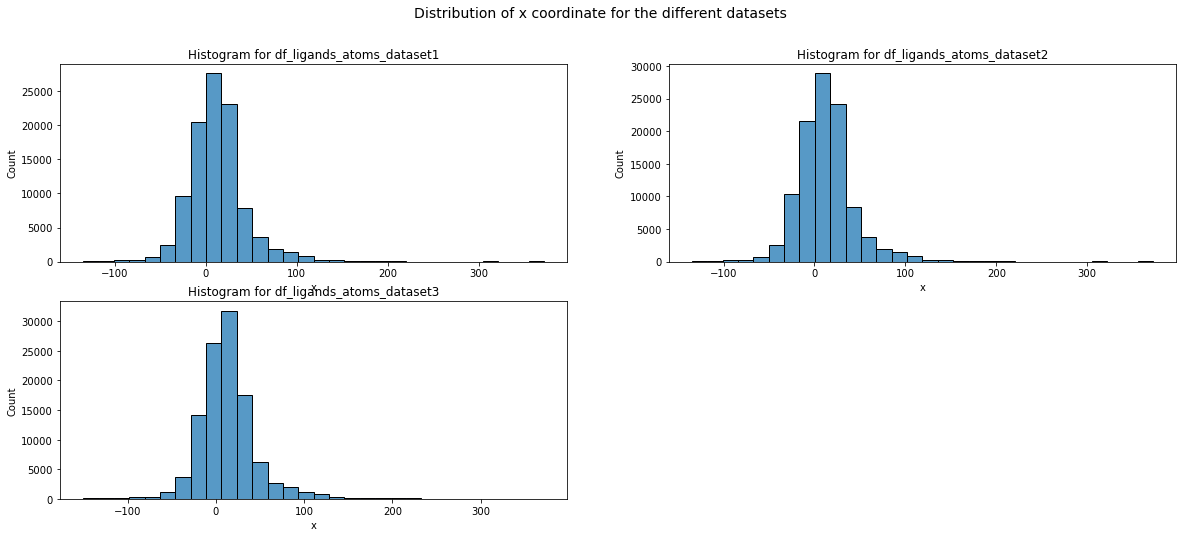

In [76]:
plt.figure(figsize=(20,8))
plt.suptitle("Distribution of x coordinate for the different datasets", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='x',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='x',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='x',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset3')

print('We can that there are outliers for x in the three datasets.')

We can that there are outliers for y in the three datasets.


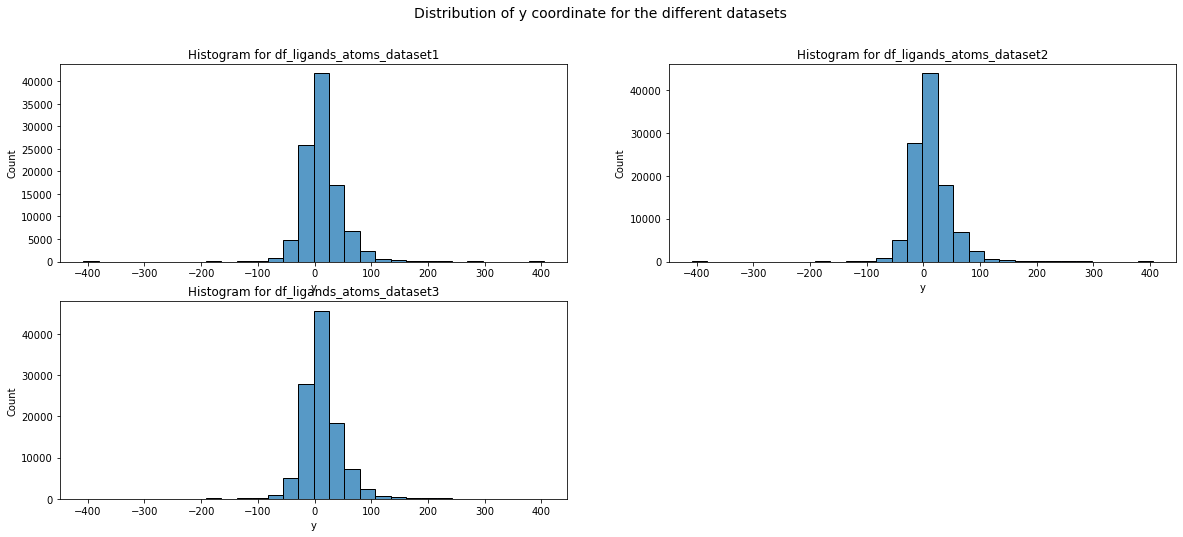

In [77]:
plt.figure(figsize=(20,8))
plt.suptitle("Distribution of y coordinate for the different datasets", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='y',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='y',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='y',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset3')

print('We can that there are outliers for y in the three datasets.')

We can that there are outliers for z in the three datasets.


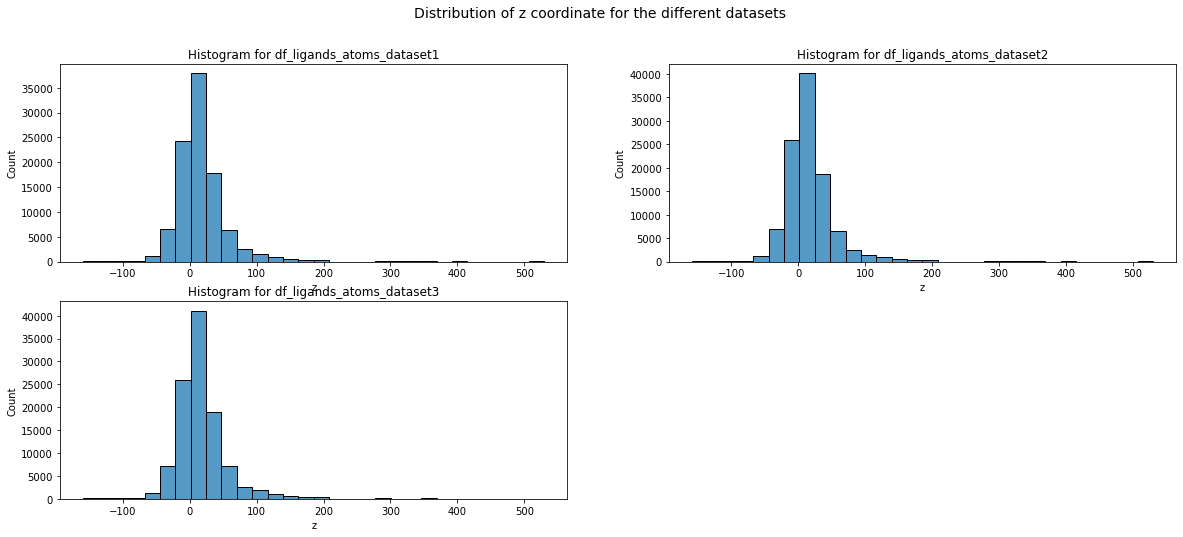

In [78]:
plt.figure(figsize=(20,8))
plt.suptitle("Distribution of z coordinate for the different datasets", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='z',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='z',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='z',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset3')

print('We can that there are outliers for z in the three datasets.')

Following this quick EDA, to squeeze these outliers, I will log the x,y and z coordinates. But, beforehand, we need to make sure all values are strictly positive to be able to apply log. To do so, we will add to all values (min + 1) to make the minimum value being 1.

In [79]:
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3,df_ligands_atoms_test]:
    dataset['log_x'] = np.log(dataset.x)
    dataset['log_y'] = np.log(dataset.y)
    dataset['log_z'] = np.log(dataset.z)

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

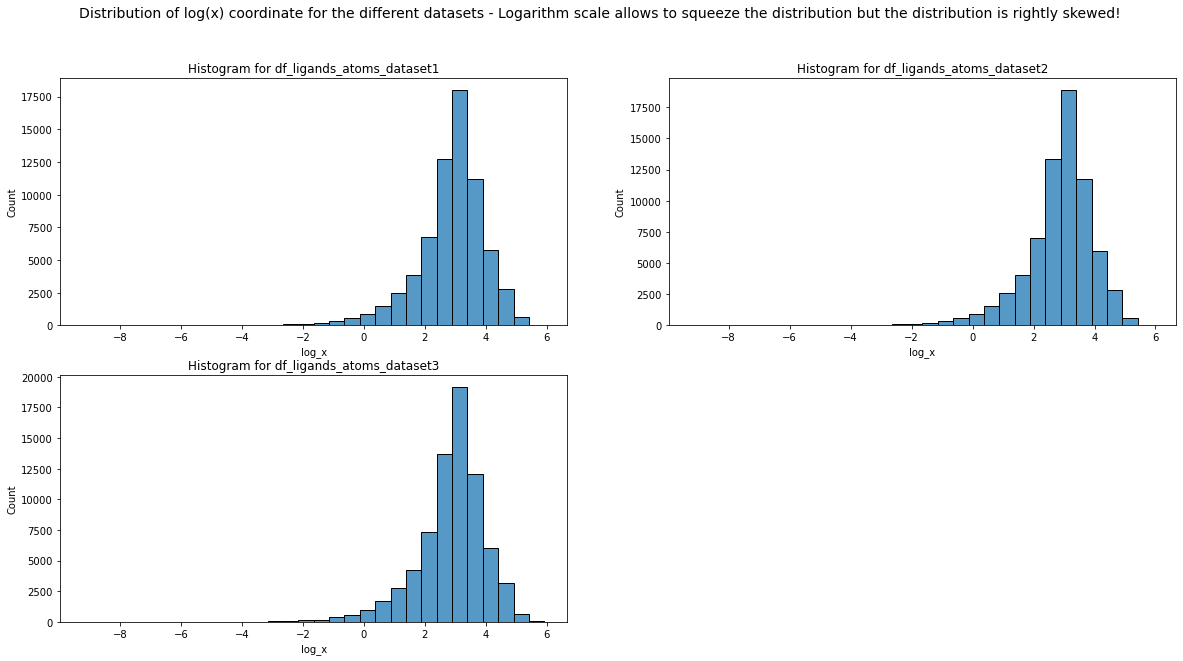

In [80]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of log(x) coordinate for the different datasets - Logarithm scale allows to squeeze the distribution but the distribution is rightly skewed!", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_x',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_x',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_x',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset3')

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

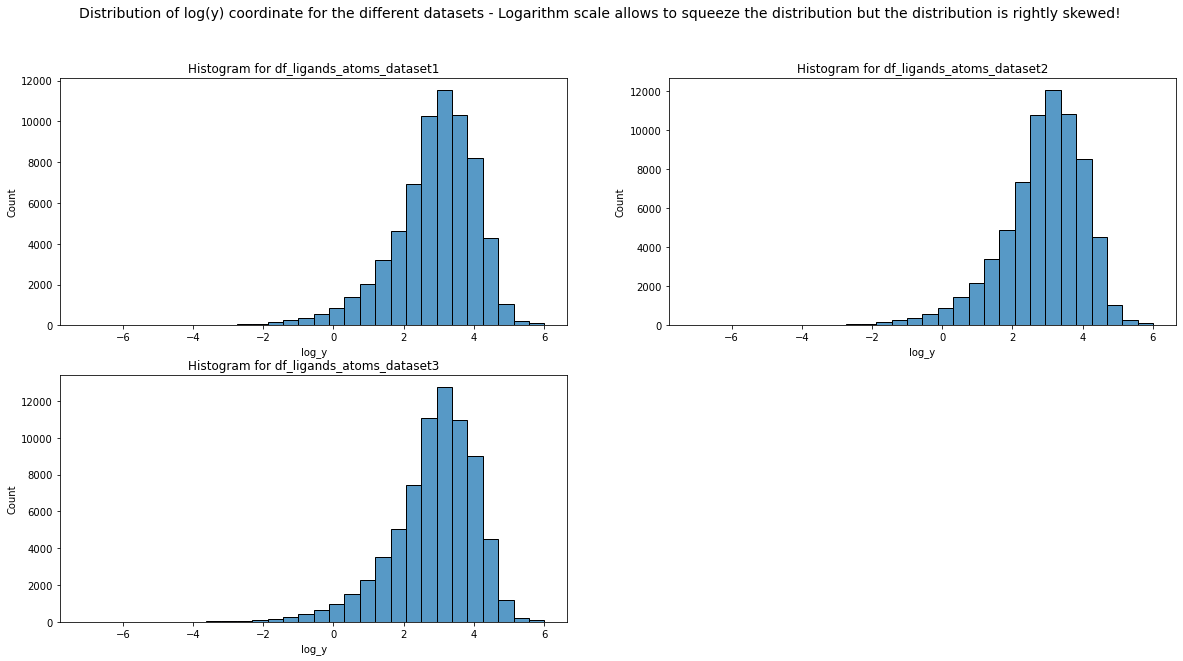

In [81]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of log(y) coordinate for the different datasets - Logarithm scale allows to squeeze the distribution but the distribution is rightly skewed!", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_y',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_y',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_y',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset3')

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

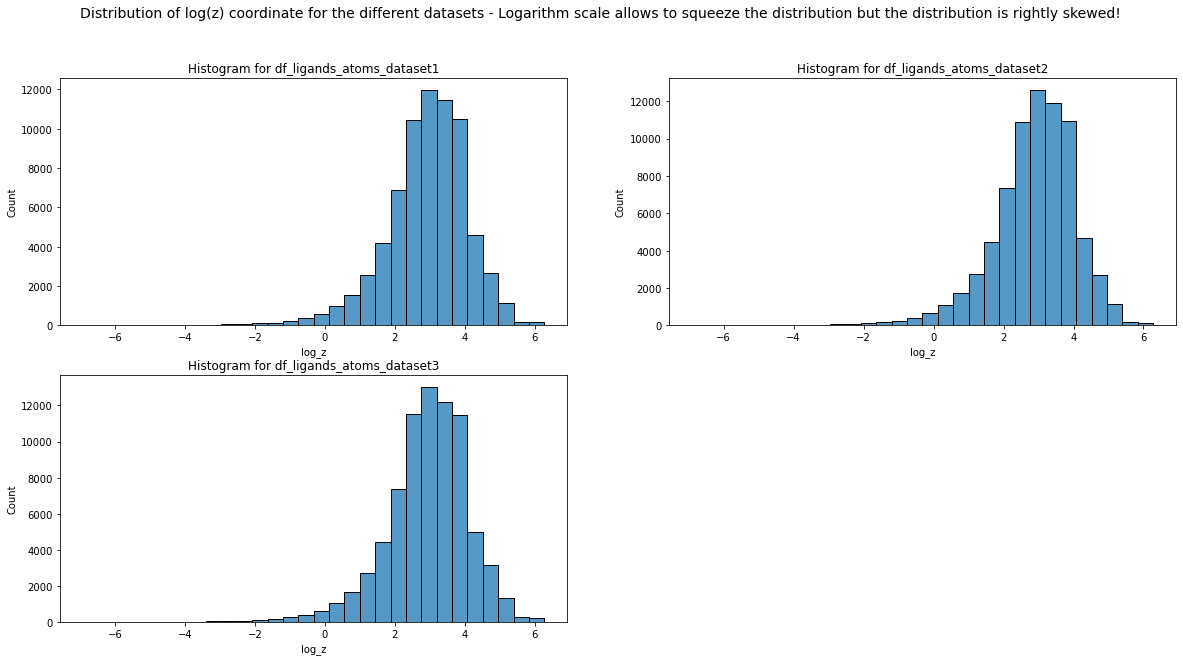

In [82]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of log(z) coordinate for the different datasets - Logarithm scale allows to squeeze the distribution but the distribution is rightly skewed!", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_z',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_z',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_z',bins=30)
plt.title('Histogram for df_ligands_atoms_dataset3')

In [83]:
""" Here, we want to shif the sample of values to make the minimum value equal to 1 (as log is define within R+*) """
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3,df_ligands_atoms_test]:
    dataset['x_shifted'] = dataset.x - dataset.x.min() + 1 
    dataset['y_shifted'] = dataset.y - dataset.y.min() + 1 
    dataset['z_shifted'] = dataset.z - dataset.z.min() + 1 

In [84]:
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3,df_ligands_atoms_test]:
    dataset['log_x'] = np.log(dataset.x_shifted)
    dataset['log_y'] = np.log(dataset.y_shifted)
    dataset['log_z'] = np.log(dataset.z_shifted)

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

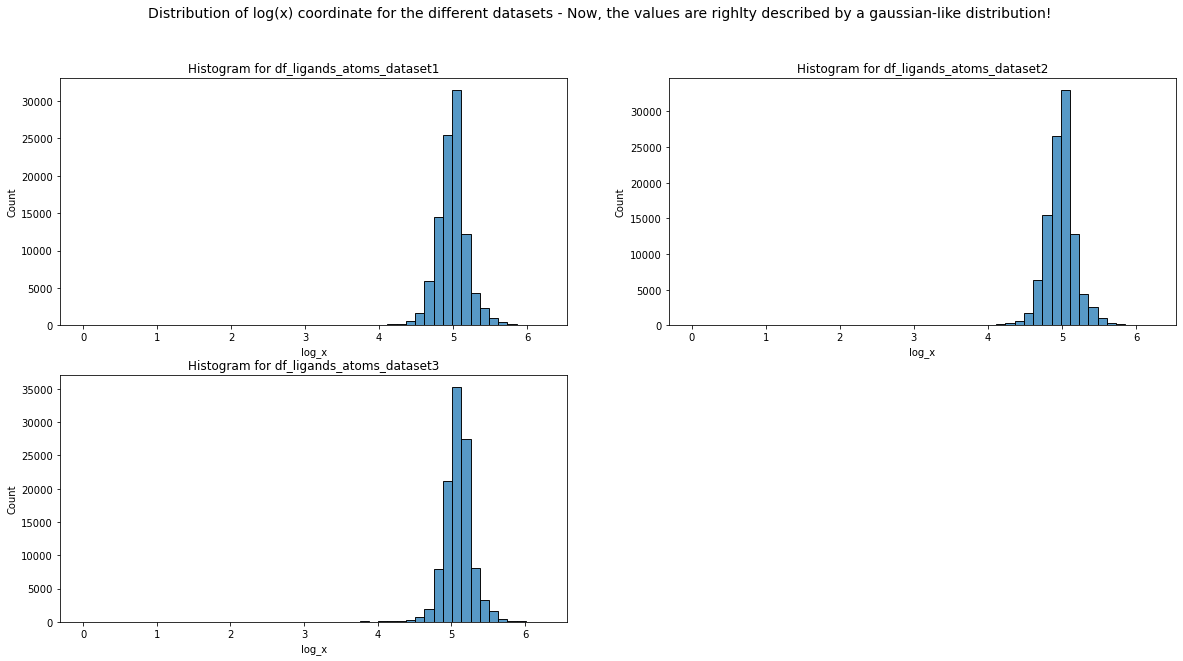

In [85]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of log(x) coordinate for the different datasets - Now, the values are righlty described by a gaussian-like distribution!", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_x',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_x',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_x',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset3')

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

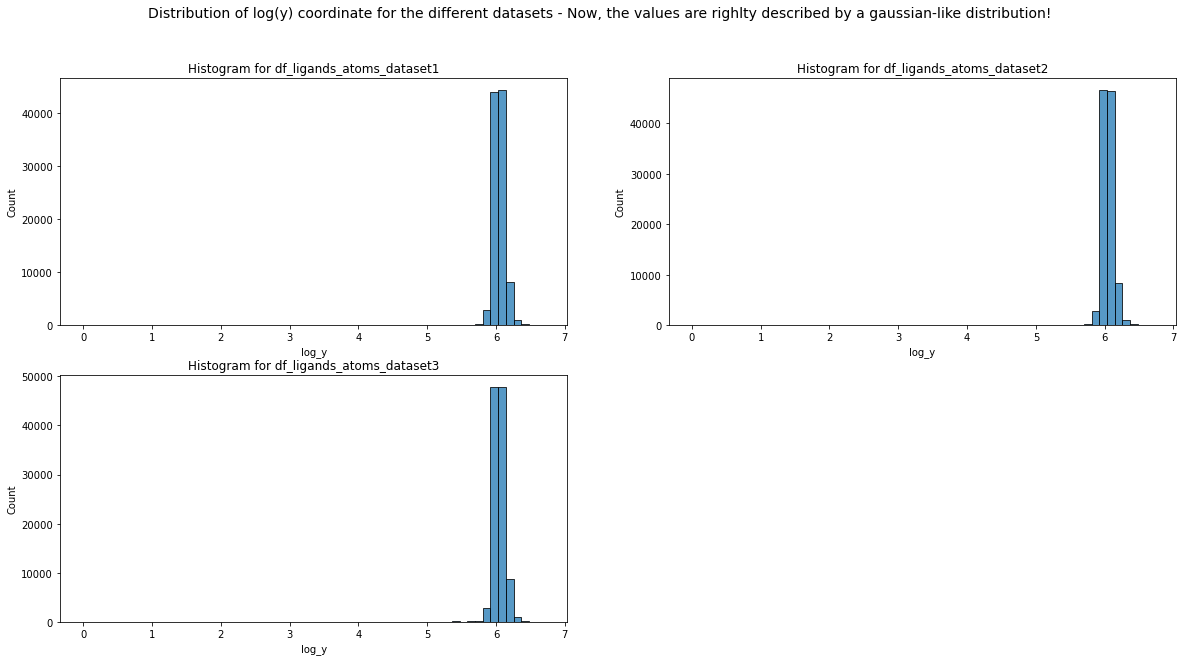

In [86]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of log(y) coordinate for the different datasets - Now, the values are righlty described by a gaussian-like distribution!", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_y',bins=60)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_y',bins=60)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_y',bins=60)
plt.title('Histogram for df_ligands_atoms_dataset3')

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

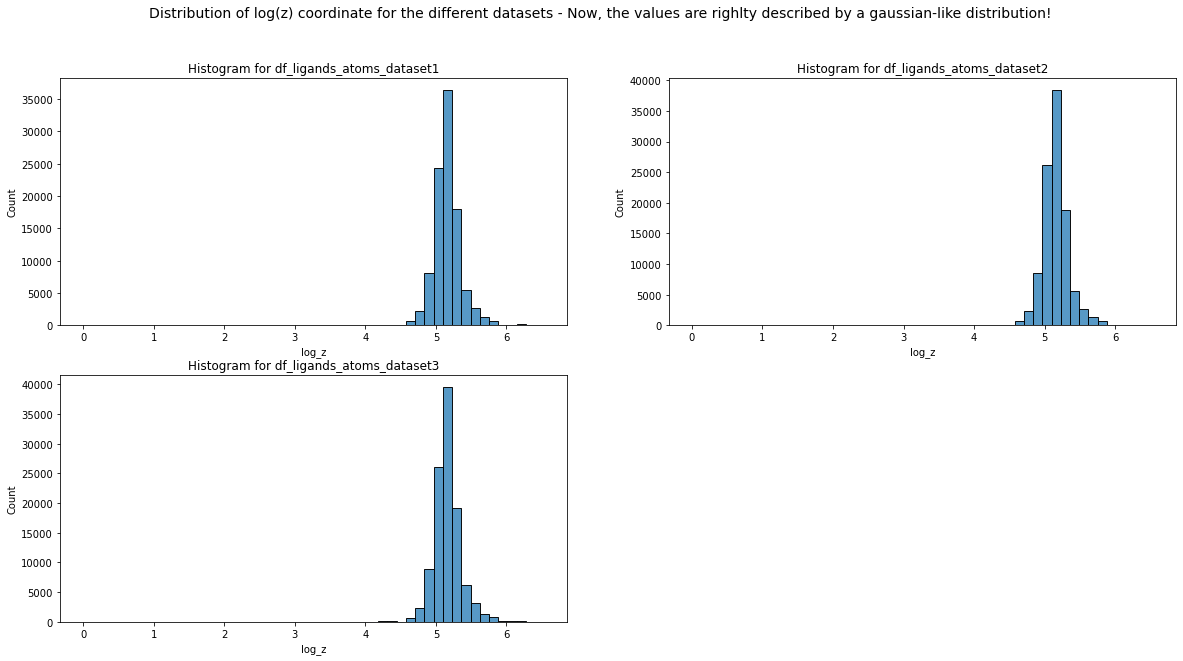

In [87]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of log(z) coordinate for the different datasets - Now, the values are righlty described by a gaussian-like distribution!", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_z',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_z',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_z',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset3')

In [88]:
""" Here, we want to normalize the data to make it between 0 and 1 """ 
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3,df_ligands_atoms_test]:
    dataset['log_x_normalized'] = (dataset.log_x - dataset.log_x.min()) / (dataset.log_x.max() - dataset.log_x.min())
    dataset['log_y_normalized'] = (dataset.log_y - dataset.log_y.min()) / (dataset.log_y.max() - dataset.log_y.min())
    dataset['log_z_normalized'] = (dataset.log_z - dataset.log_z.min()) / (dataset.log_z.max() - dataset.log_z.min())

In [89]:
# Dataset 1
atoms_df_dataset1 = df_ligands_atoms_dataset1.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'lig_distances'}).drop(labels='level_1',axis=1)
lig_distances_df1 = atoms_df_dataset1.groupby(by='pdb_code').mean().reset_index()

# Dataset 2
atoms_df_dataset2 = df_ligands_atoms_dataset2.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'lig_distances'}).drop(labels='level_1',axis=1)
lig_distances_df2 = atoms_df_dataset2.groupby(by='pdb_code').mean().reset_index()

# Dataset 3
atoms_df_dataset3 = df_ligands_atoms_dataset3.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'lig_distances'}).drop(labels='level_1',axis=1)
lig_distances_df3 = atoms_df_dataset3.groupby(by='pdb_code').mean().reset_index()

# Test
atoms_df_test = df_ligands_atoms_test.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'lig_distances'}).drop(labels='level_1',axis=1)
lig_distances_test = atoms_df_test.groupby(by='pdb_code').mean().reset_index()

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

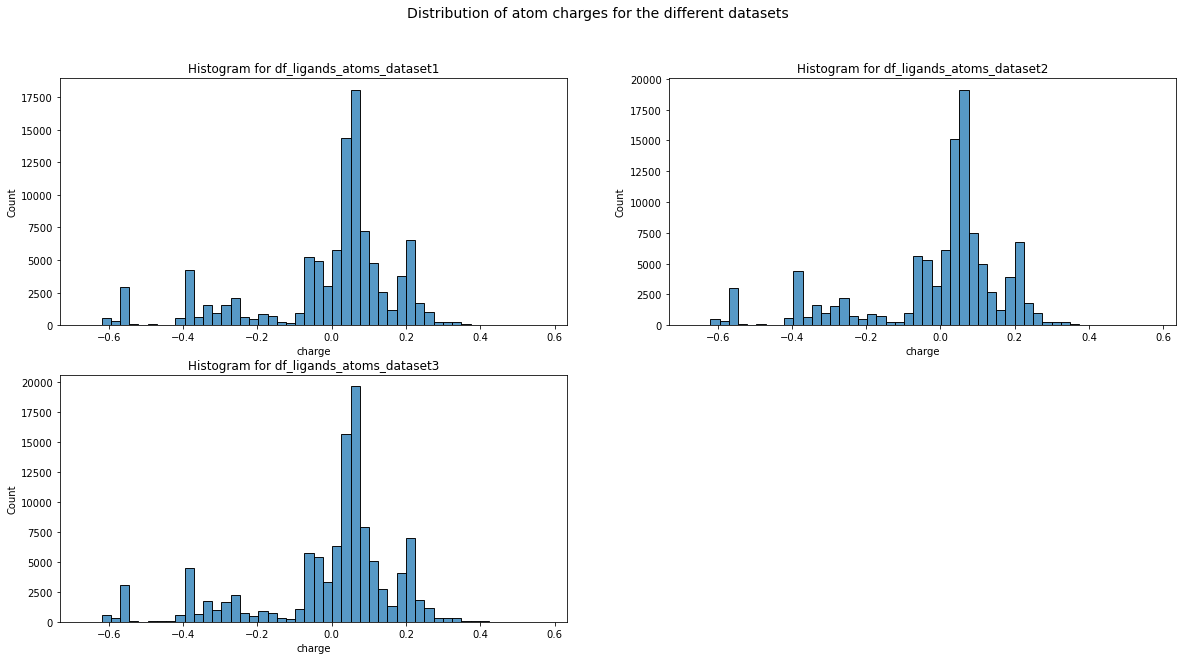

In [90]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of atom charges for the different datasets ", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='charge',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='charge',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='charge',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset3')

In [91]:
# Dataset 1
lig_sum_charge_df1 = df_ligands_atoms_dataset1.groupby('pdb_code').sum().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_sum_charge'})
lig_mean_charge_df1 = df_ligands_atoms_dataset1.groupby('pdb_code').mean().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_mean_charge'})
lig_median_charge_df1 = df_ligands_atoms_dataset1.groupby('pdb_code').median().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_median_charge'})
lig_charge_df1 = lig_sum_charge_df1.merge(lig_mean_charge_df1,on='pdb_code',how='inner')
lig_charge_df1 = lig_charge_df1.merge(lig_median_charge_df1,on='pdb_code',how='inner')
lig_charge_df1['lig_sum_mean_diff'] = lig_charge_df1['lig_sum_charge'] - lig_charge_df1['lig_mean_charge']
lig_charge_df1['lig_sum_median_diff'] = lig_charge_df1['lig_sum_charge'] - lig_charge_df1['lig_median_charge']

# Dataset 2
lig_sum_charge_df2 = df_ligands_atoms_dataset2.groupby('pdb_code').sum().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_sum_charge'})
lig_mean_charge_df2 = df_ligands_atoms_dataset2.groupby('pdb_code').mean().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_mean_charge'})
lig_median_charge_df2 = df_ligands_atoms_dataset2.groupby('pdb_code').median().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_median_charge'})
lig_charge_df2 = lig_sum_charge_df2.merge(lig_mean_charge_df2,on='pdb_code',how='inner')
lig_charge_df2 = lig_charge_df2.merge(lig_median_charge_df2,on='pdb_code',how='inner')
lig_charge_df2['lig_sum_mean_diff'] = lig_charge_df2['lig_sum_charge'] - lig_charge_df2['lig_mean_charge']
lig_charge_df2['lig_sum_median_diff'] = lig_charge_df2['lig_sum_charge'] - lig_charge_df2['lig_median_charge']

# Dataset 3
lig_sum_charge_df3 = df_ligands_atoms_dataset3.groupby('pdb_code').sum().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_sum_charge'})
lig_mean_charge_df3 = df_ligands_atoms_dataset3.groupby('pdb_code').mean().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_mean_charge'})
lig_median_charge_df3 = df_ligands_atoms_dataset3.groupby('pdb_code').median().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_median_charge'})
lig_charge_df3 = lig_sum_charge_df3.merge(lig_mean_charge_df3,on='pdb_code',how='inner')
lig_charge_df3 = lig_charge_df3.merge(lig_median_charge_df3,on='pdb_code',how='inner')
lig_charge_df3['lig_sum_mean_diff'] = lig_charge_df3['lig_sum_charge'] - lig_charge_df3['lig_mean_charge']
lig_charge_df3['lig_sum_median_diff'] = lig_charge_df3['lig_sum_charge'] - lig_charge_df3['lig_median_charge']

# Test
lig_sum_charge_test = df_ligands_atoms_test.groupby('pdb_code').sum().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_sum_charge'})
lig_mean_charge_test = df_ligands_atoms_test.groupby('pdb_code').mean().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_mean_charge'})
lig_median_charge_test = df_ligands_atoms_test.groupby('pdb_code').median().reset_index()[['pdb_code','charge']].rename(columns={'charge':'lig_median_charge'})
lig_charge_test = lig_sum_charge_test.merge(lig_mean_charge_test,on='pdb_code',how='inner')
lig_charge_test = lig_charge_test.merge(lig_median_charge_test,on='pdb_code',how='inner')
lig_charge_test['lig_sum_mean_diff'] = lig_charge_test['lig_sum_charge'] - lig_charge_test['lig_mean_charge']
lig_charge_test['lig_sum_median_diff'] = lig_charge_test['lig_sum_charge'] - lig_charge_test['lig_median_charge']

In [92]:
""" Here, we will build the final 'df_lig_atoms_dat1_f' with all features """

# Dataset 1
df_lig_atoms_dat1_f = lig_distances_df1.merge(lig_charge_df1,how='left',on='pdb_code')
print(df_lig_atoms_dat1_f.shape)

# Dataset 2
df_lig_atoms_dat2_f = lig_distances_df2.merge(lig_charge_df2,how='left',on='pdb_code')
print(df_lig_atoms_dat2_f.shape)

# Dataset 3
df_lig_atoms_dat3_f = lig_distances_df3.merge(lig_charge_df3,how='left',on='pdb_code')
print(df_lig_atoms_dat3_f.shape)

# Test
df_lig_atoms_test_f = lig_distances_test.merge(lig_charge_test,how='left',on='pdb_code')
print(df_lig_atoms_test_f.shape)

(2252, 7)
(2374, 7)
(2421, 7)
(285, 7)


Text(0.5, 1.0, 'Countplot for df_ligands_atoms_dataset3')

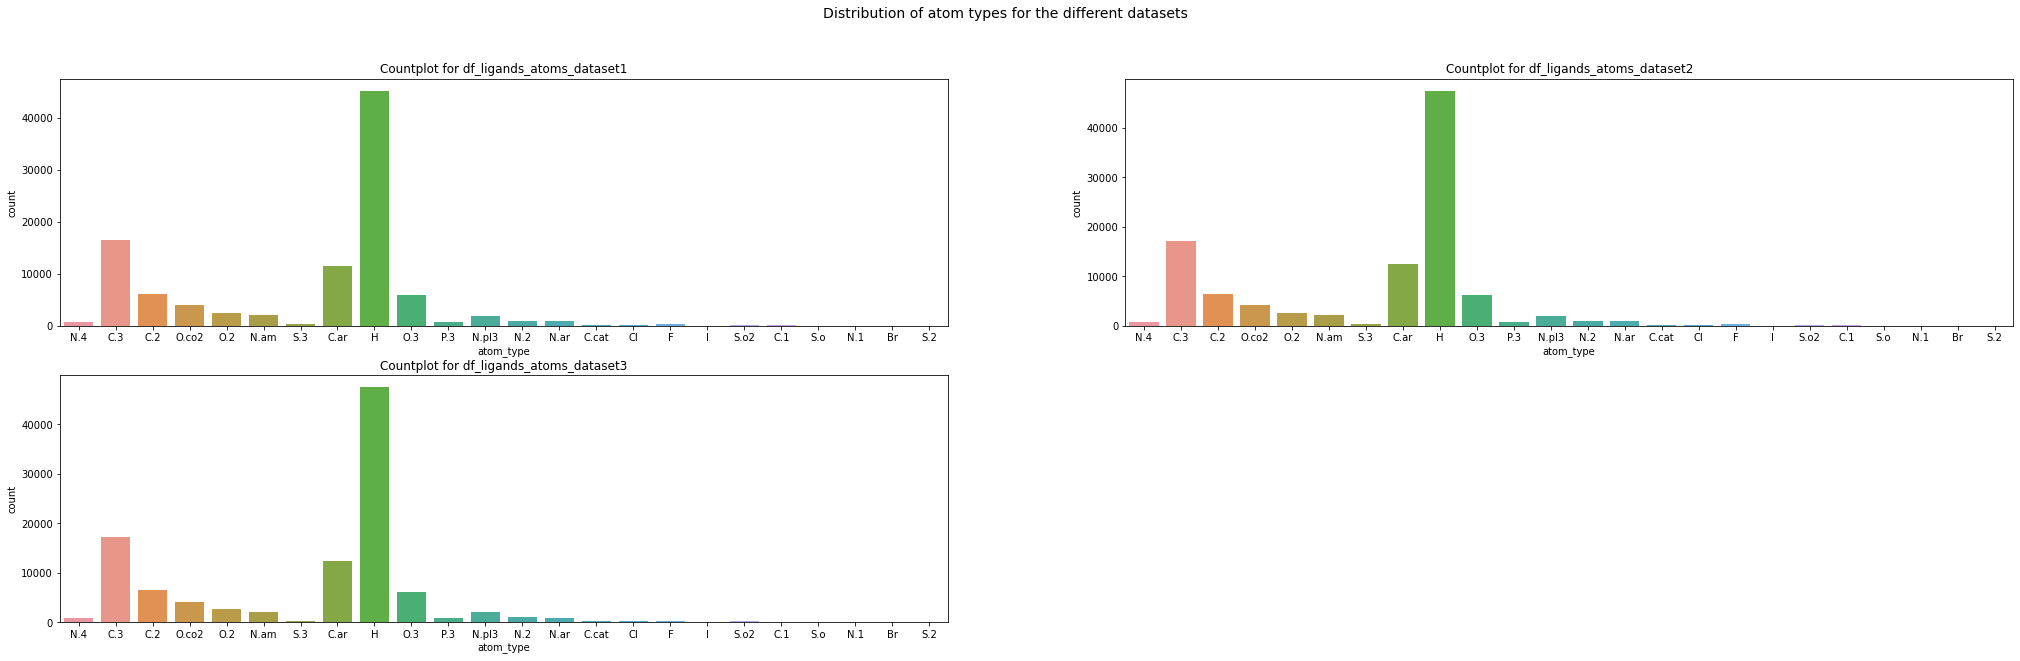

In [93]:
plt.figure(figsize=(35,10))
plt.suptitle("Distribution of atom types for the different datasets", fontsize=14)

plt.subplot(2,2,1)
sns.countplot(data=df_ligands_atoms_dataset1,x='atom_type')
plt.title('Countplot for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.countplot(data=df_ligands_atoms_dataset2,x='atom_type')
plt.title('Countplot for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.countplot(data=df_ligands_atoms_dataset2,x='atom_type')
plt.title('Countplot for df_ligands_atoms_dataset3')

In [94]:
""" Here, we calculate the number of atom types there are for each protein """ 
# Dataset 1
lig_atom_type_count_dataset1 = df_ligands_atoms_dataset1.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Dataset 2
lig_atom_type_count_dataset2 = df_ligands_atoms_dataset2.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Dataset 3 
lig_atom_type_count_dataset3 = df_ligands_atoms_dataset3.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Test 
lig_atom_type_count_test = df_ligands_atoms_test.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

In [95]:
""" Here, we calculate the average number of atom types for each protein """ 
# Dataset 1 
lig_atom_type_mean_dataset1 = df_ligands_atoms_dataset1.groupby(['pdb_code','atom_type']).count()['atom_id'] / df_ligands_atoms_dataset1.groupby(['pdb_code']).count()['atom_type']
lig_atom_type_mean_dataset1 = lig_atom_type_mean_dataset1.reset_index().rename(columns={0:'lig_atom_type_mean'})

# Dataset 2
lig_atom_type_mean_dataset2 = df_ligands_atoms_dataset2.groupby(['pdb_code','atom_type']).count()['atom_id'] / df_ligands_atoms_dataset2.groupby(['pdb_code']).count()['atom_type']
lig_atom_type_mean_dataset2 = lig_atom_type_mean_dataset2.reset_index().rename(columns={0:'lig_atom_type_mean'})

# Dataset 3
lig_atom_type_mean_dataset3 = df_ligands_atoms_dataset3.groupby(['pdb_code','atom_type']).count()['atom_id'] / df_ligands_atoms_dataset3.groupby(['pdb_code']).count()['atom_type']
lig_atom_type_mean_dataset3 = lig_atom_type_mean_dataset3.reset_index().rename(columns={0:'lig_atom_type_mean'})

# Test 
lig_atom_type_mean_test = df_ligands_atoms_test.groupby(['pdb_code','atom_type']).count()['atom_id'] / df_ligands_atoms_test.groupby(['pdb_code']).count()['atom_type']
lig_atom_type_mean_test = lig_atom_type_mean_test.reset_index().rename(columns={0:'lig_atom_type_mean'})

In [96]:
""" Here, we make the difference between the number of atom types and its average """ 
# Dataset 1 
lig_atom_type_count_mean_dataset1 = lig_atom_type_count_dataset1.merge(lig_atom_type_mean_dataset1,how='left',on='pdb_code')
lig_atom_type_count_mean_dataset1['lig_atom_type_count_mean_diff'] = lig_atom_type_count_mean_dataset1['lig_atom_type_count'] - lig_atom_type_count_mean_dataset1['lig_atom_type_mean']
lig_atom_type_count_mean_dataset1 = lig_atom_type_count_mean_dataset1.drop(labels='atom_type_y',axis=1).rename(columns={'atom_type_x':'atom_type'})

# Dataset 2
lig_atom_type_count_mean_dataset2 = lig_atom_type_count_dataset2.merge(lig_atom_type_mean_dataset2,how='left',on='pdb_code')
lig_atom_type_count_mean_dataset2['lig_atom_type_count_mean_diff'] = lig_atom_type_count_mean_dataset2['lig_atom_type_count'] - lig_atom_type_count_mean_dataset2['lig_atom_type_mean']
lig_atom_type_count_mean_dataset2 = lig_atom_type_count_mean_dataset2.drop(labels='atom_type_y',axis=1).rename(columns={'atom_type_x':'atom_type'})

# Dataset 3
lig_atom_type_count_mean_dataset3 = lig_atom_type_count_dataset3.merge(lig_atom_type_mean_dataset3,how='left',on='pdb_code')
lig_atom_type_count_mean_dataset3['lig_atom_type_count_mean_diff'] = lig_atom_type_count_mean_dataset3['lig_atom_type_count'] - lig_atom_type_count_mean_dataset3['lig_atom_type_mean']
lig_atom_type_count_mean_dataset3 = lig_atom_type_count_mean_dataset3.drop(labels='atom_type_y',axis=1).rename(columns={'atom_type_x':'atom_type'})

# Test
lig_atom_type_count_mean_test = lig_atom_type_count_test.merge(lig_atom_type_mean_test,how='left',on='pdb_code')
lig_atom_type_count_mean_test['lig_atom_type_count_mean_diff'] = lig_atom_type_count_mean_test['lig_atom_type_count'] - lig_atom_type_count_mean_test['lig_atom_type_mean']
lig_atom_type_count_mean_test = lig_atom_type_count_mean_test.drop(labels='atom_type_y',axis=1).rename(columns={'atom_type_x':'atom_type'})

In [97]:
def insert_atom_types_nb(dataset,dataset_f):
    """ 
        This function allows to count the number of atom types within each ligand and 
        creates a column for each type of atom 
                                                                                        """
    for col in dataset.atom_type.unique():
        atom_type_count =  dataset[dataset['atom_type'] == col][['pdb_code','lig_atom_type_count']].rename(columns={'lig_atom_type_count':'lig_'+col+'_atom_count'})
        dataset_f = dataset_f.merge(atom_type_count,how='left',on='pdb_code')
    return dataset_f

def insert_atom_types_mean(dataset,dataset_f):
    """ 
        This function allows to count the number of atom types within each ligand and 
        creates a column for each type of atom 
                                                                                        """
    for col in dataset.atom_type.unique():
        atom_type_count =  dataset[dataset['atom_type'] == col][['pdb_code','lig_atom_type_mean']].rename(columns={'lig_atom_type_mean':'lig_'+col+'_atom_mean'})
        dataset_f = dataset_f.merge(atom_type_count,how='left',on='pdb_code')
    return dataset_f

def insert_atom_types_count_mean_diff(dataset,dataset_f):
    """ 
        This function allows to count the number of atom types within each ligand and 
        creates a column for each type of atom 
                                                                                        """
    for col in dataset.atom_type.unique():
        atom_type_count =  dataset[dataset['atom_type'] == col][['pdb_code','lig_atom_type_count_mean_diff']].rename(columns={'lig_atom_type_count_mean_diff':'lig_'+col+'_atom_count_mean_diff'})
        dataset_f = dataset_f.merge(atom_type_count,how='left',on='pdb_code')
    return dataset_f

In [98]:
""" Here, we insert number of atom types columns """ 
# Dataset 1
df_lig_atoms_dat1_f =  insert_atom_types_nb(lig_atom_type_count_dataset1,df_lig_atoms_dat1_f)

# Dataset 2
df_lig_atoms_dat2_f =  insert_atom_types_nb(lig_atom_type_count_dataset2,df_lig_atoms_dat2_f)

# Dataset 3 
df_lig_atoms_dat3_f =  insert_atom_types_nb(lig_atom_type_count_dataset3,df_lig_atoms_dat3_f)

# Test
df_lig_atoms_test_f =  insert_atom_types_nb(lig_atom_type_count_test,df_lig_atoms_test_f)

In [99]:
""" Here, we insert average number of atom types columns """ 
# Dataset 1
df_lig_atoms_dat1_f =  insert_atom_types_mean(lig_atom_type_mean_dataset1,df_lig_atoms_dat1_f)

# Dataset 2
df_lig_atoms_dat2_f =  insert_atom_types_mean(lig_atom_type_mean_dataset2,df_lig_atoms_dat2_f)

# Dataset 3 
df_lig_atoms_dat3_f =  insert_atom_types_mean(lig_atom_type_mean_dataset3,df_lig_atoms_dat3_f)

# Test
df_lig_atoms_test_f =  insert_atom_types_mean(lig_atom_type_mean_test,df_lig_atoms_test_f)

In [100]:
# Dataset 1
df_lig_atoms_dat1_f.fillna(0,inplace=True)

# Dataset 2
df_lig_atoms_dat2_f.fillna(0,inplace=True)

# Dataset 3
df_lig_atoms_dat3_f.fillna(0,inplace=True)

# Test
df_lig_atoms_test_f.fillna(0,inplace=True)

## Feature engineering on df_proteins : 

### x,y and z FE with preprocessing

In [101]:
# Training data 
df_proteins_dataset1.drop(columns=['blank_1','blank_2','blank_3','blank_4'],axis=1,inplace=True)
df_proteins_dataset2.drop(columns=['blank_1','blank_2','blank_3','blank_4'],axis=1,inplace=True)
df_proteins_dataset3.drop(columns=['blank_1','blank_2','blank_3','blank_4'],axis=1,inplace=True)

df_proteins_dataset1.drop(columns=['alt_loc','insertion','segment_id'],axis=1,inplace=True)
df_proteins_dataset2.drop(columns=['alt_loc','insertion','segment_id'],axis=1,inplace=True)
df_proteins_dataset3.drop(columns=['alt_loc','insertion','segment_id'],axis=1,inplace=True)

df_proteins_dataset1.drop(columns=['charge'],axis=1,inplace=True)
df_proteins_dataset2.drop(columns=['charge'],axis=1,inplace=True)
df_proteins_dataset3.drop(columns=['charge'],axis=1,inplace=True)

# Test data
df_proteins_test.drop(columns=['blank_1','blank_2','blank_3','blank_4'],axis=1,inplace=True)
df_proteins_test.drop(columns=['alt_loc','insertion','segment_id'],axis=1,inplace=True)
df_proteins_test.drop(columns=['charge'],axis=1,inplace=True)


In [102]:
for dataset in [df_proteins_dataset1, df_proteins_dataset2, df_proteins_dataset3,df_proteins_test]:
    dataset['log_x'] = np.log(dataset.x_coord)
    dataset['log_y'] = np.log(dataset.y_coord)
    dataset['log_z'] = np.log(dataset.z_coord)

In [103]:
""" Here, we want to shif the sample of values to make the minimum value equal to 1 (as log is define within R+*) """
for dataset in [df_proteins_dataset1, df_proteins_dataset2, df_proteins_dataset3, df_proteins_test]:
    dataset['x_shifted'] = dataset.x_coord - dataset.x_coord.min() + 1 
    dataset['y_shifted'] = dataset.y_coord - dataset.y_coord.min() + 1 
    dataset['z_shifted'] = dataset.z_coord - dataset.z_coord.min() + 1 

In [104]:
for dataset in [df_proteins_dataset1, df_proteins_dataset2, df_proteins_dataset3, df_proteins_test]:
    dataset['log_x'] = np.log(dataset.x_shifted)
    dataset['log_y'] = np.log(dataset.y_shifted)
    dataset['log_z'] = np.log(dataset.z_shifted)

In [105]:
""" Here, we want to normalize the data to make it between 0 and 1 """ 
for dataset in [df_proteins_dataset1, df_proteins_dataset2, df_proteins_dataset3, df_proteins_test]:
    dataset['log_x_normalized'] = (dataset.log_x - dataset.log_x.min()) / (dataset.log_x.max() - dataset.log_x.min())
    dataset['log_y_normalized'] = (dataset.log_y - dataset.log_y.min()) / (dataset.log_y.max() - dataset.log_y.min())
    dataset['log_z_normalized'] = (dataset.log_z - dataset.log_z.min()) / (dataset.log_z.max() - dataset.log_z.min())

In [106]:
# Dataset 1
prot_df_dataset1 = df_proteins_dataset1.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_df1 = prot_df_dataset1.groupby(by='pdb_code').mean().reset_index()

# Dataset 2
prot_df_dataset2 = df_proteins_dataset2.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_df2 = prot_df_dataset2.groupby(by='pdb_code').mean().reset_index()

# Dataset 3
prot_df_dataset3 = df_proteins_dataset3.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_df3 = prot_df_dataset3.groupby(by='pdb_code').mean().reset_index()

# Test
prot_df_test = df_proteins_test.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_test = prot_df_test.groupby(by='pdb_code').mean().reset_index()

### Residue name FE without preprocessing

In [107]:
# Train
nb_residues_df = df_proteins_dataset1.groupby(by=['pdb_code','residue_name']).count().reset_index()[['pdb_code','residue_name','residue_number']].rename(columns={'residue_number':'prot_nb_residues'})
mean_residues_df = df_proteins_dataset1.groupby(by=['pdb_code','residue_name']).mean().reset_index()[['pdb_code','residue_name','residue_number']].rename(columns={'residue_number':'prot_mean_residues'})
residues_df = nb_residues_df.merge(mean_residues_df,how='left',on=['pdb_code','residue_name'])
residues_df['prot_nb_mean_residues_diff'] = residues_df.prot_nb_residues - residues_df.prot_mean_residues

# Test
nb_residues_df_test = df_proteins_test.groupby(by=['pdb_code','residue_name']).count().reset_index()[['pdb_code','residue_name','residue_number']].rename(columns={'residue_number':'prot_nb_residues'})
mean_residues_df_test = df_proteins_test.groupby(by=['pdb_code','residue_name']).mean().reset_index()[['pdb_code','residue_name','residue_number']].rename(columns={'residue_number':'prot_mean_residues'})
residues_df_test = nb_residues_df_test.merge(mean_residues_df_test,how='left',on=['pdb_code','residue_name'])
residues_df_test['prot_nb_mean_residues_diff'] = residues_df_test.prot_nb_residues - residues_df_test.prot_mean_residues

In [108]:
def insert_residues_df(dataset,dataset_f):
    for col in dataset.residue_name.unique():
        residues_name_cols =  dataset[dataset['residue_name'] == col][['pdb_code','prot_nb_residues','prot_mean_residues','prot_nb_mean_residues_diff']].rename(columns={'prot_nb_residues':col+'_prot_nb_residues','prot_mean_residues':col+'_prot_mean_residues','prot_nb_mean_residues_diff':col+'_prot_nb_mean_residues_diff'})
        dataset_f = dataset_f.merge(residues_name_cols,how='left',on='pdb_code')
    return dataset_f

In [109]:
# Dataset 1
df_prot_dat1_f = insert_residues_df(residues_df,prot_distances_df1)

# Dataset 2
df_prot_dat2_f = insert_residues_df(residues_df,prot_distances_df2)

# Dataset 3
df_prot_dat3_f = insert_residues_df(residues_df,prot_distances_df3)

# Test
df_prot_test_f = insert_residues_df(residues_df_test,prot_distances_test)

In [110]:
df_prot_test_f

,pdb_code,prot_distances,ALA_prot_nb_residues,ALA_prot_mean_residues,ALA_prot_nb_mean_residues_diff,ARG_prot_nb_residues,ARG_prot_mean_residues,ARG_prot_nb_mean_residues_diff,ASN_prot_nb_residues,ASN_prot_mean_residues,...,THR_prot_nb_mean_residues_diff,TRP_prot_nb_residues,TRP_prot_mean_residues,TRP_prot_nb_mean_residues_diff,TYR_prot_nb_residues,TYR_prot_mean_residues,TYR_prot_nb_mean_residues_diff,VAL_prot_nb_residues,VAL_prot_mean_residues,VAL_prot_nb_mean_residues_diff
0,1a30,1.510464,60,40.333333,19.666667,177,48.864407,128.135593,84,89.666667,...,172.250000,96.0,24.000000,72.000000,42,59.000000,-17.000000,192,55.500000,136.500000
1,1bcu,1.545174,121,95.710744,25.289256,480,115.450000,364.550000,140,128.300000,...,9.666667,192.0,129.500000,62.500000,231,129.909091,101.090909,256,138.812500,117.187500
2,1bzc,1.505614,130,139.538462,-9.538462,408,135.647059,272.352941,140,95.300000,...,14.384615,144.0,134.500000,9.500000,189,121.000000,68.000000,256,171.062500,84.937500
3,1c5z,1.498279,110,114.636364,-4.636364,312,126.384615,185.615385,84,82.000000,...,131.210526,120.0,143.600000,-23.600000,252,113.083333,138.916667,192,137.333333,54.666667
4,1e66,1.578254,460,267.826087,192.173913,1102,258.896552,843.103448,942,289.414013,...,316.922330,672.0,273.928571,398.071429,714,255.705882,458.294118,1280,245.300000,1034.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,5aba,1.562229,80,171.750000,-91.750000,432,219.222222,212.777778,98,224.857143,...,14.000000,24.0,146.000000,-122.000000,168,176.625000,-8.625000,224,187.857143,36.142857
281,5c28,1.521570,160,627.437500,-467.437500,336,594.928571,-258.928571,196,603.285714,...,-323.571429,144.0,591.666667,-447.666667,252,598.333333,-346.333333,240,591.400000,-351.400000
282,5c2h,1.565326,160,627.437500,-467.437500,321,601.373832,-280.373832,196,603.285714,...,-330.400000,144.0,591.666667,-447.666667,252,598.333333,-346.333333,240,591.400000,-351.400000
283,5dwr,1.427104,90,190.111111,-100.111111,504,179.857143,324.142857,79,161.215190,...,-101.428571,168.0,190.142857,-22.142857,147,166.000000,-19.000000,352,142.272727,209.727273


### Occupancy FE without preprocessing

In [111]:
# Dataset 1
mean_occupancy_1 = df_proteins_dataset1.groupby(by=['pdb_code'])['occupancy'].mean().reset_index()
df_prot_dat1_f = df_prot_dat1_f.merge(mean_occupancy_1,how='left',on='pdb_code')

# Dataset 2
mean_occupancy_2 = df_proteins_dataset2.groupby(by=['pdb_code'])['occupancy'].mean().reset_index()
df_prot_dat2_f = df_prot_dat2_f.merge(mean_occupancy_2,how='left',on='pdb_code')

# Dataset 3
mean_occupancy_3 = df_proteins_dataset3.groupby(by=['pdb_code'])['occupancy'].mean().reset_index()
df_prot_dat3_f = df_prot_dat3_f.merge(mean_occupancy_3,how='left',on='pdb_code')

# Test
mean_occupancy_test = df_proteins_test.groupby(by=['pdb_code'])['occupancy'].mean().reset_index()
df_prot_test_f = df_prot_test_f.merge(mean_occupancy_test,how='left',on='pdb_code')

### b_factor FE without preprocessing

In [112]:
# Dataset 1 
mean_b_factor_1 = df_proteins_dataset1.groupby(by=['pdb_code'])['b_factor'].mean().reset_index()
df_prot_dat1_f = df_prot_dat1_f.merge(mean_b_factor_1,how='left',on='pdb_code')

# Dataset 2
mean_b_factor_2 = df_proteins_dataset2.groupby(by=['pdb_code'])['b_factor'].mean().reset_index()
df_prot_dat2_f = df_prot_dat2_f.merge(mean_b_factor_2,how='left',on='pdb_code')

# Dataset 3
mean_b_factor_3 = df_proteins_dataset3.groupby(by=['pdb_code'])['b_factor'].mean().reset_index()
df_prot_dat3_f = df_prot_dat3_f.merge(mean_b_factor_3,how='left',on='pdb_code')

# Test
mean_b_factor_test = df_proteins_test.groupby(by=['pdb_code'])['b_factor'].mean().reset_index()
df_prot_test_f = df_prot_test_f.merge(mean_b_factor_test,how='left',on='pdb_code')

In [113]:
# Dataset 1
df_prot_dat1_f.fillna(0,inplace=True)

# Dataset 2
df_prot_dat2_f.fillna(0,inplace=True)

# Dataset 3
df_prot_dat3_f.fillna(0,inplace=True)

# Test
df_prot_test_f.fillna(0,inplace=True)

# Building of the final train and test datasets !! + creation of noise feature

In [114]:
mu, sigma = 0, 0.1
# Dataset 1
df_lig_dat1_f = df_lig_atoms_dat1_f.merge(df_lig_bond_dat1_f,how='inner',on='pdb_code')
df_dat1_f = df_lig_dat1_f.merge(df_prot_dat1_f,how='inner',on='pdb_code')
#df_dat1_f['noise'] = np.random.normal(mu,sigma,df_dat1_f.shape[0])
df_dat1_f = df_dat1_f.merge(binding_constants_train_dataset1[['pdb_code','pKd_or_pKi']],how='inner',on='pdb_code')

# Dataset 2 
df_lig_dat2_f = df_lig_atoms_dat2_f.merge(df_lig_bond_dat2_f,how='inner',on='pdb_code')
df_dat2_f = df_lig_dat2_f.merge(df_prot_dat2_f,how='inner',on='pdb_code')
#df_dat2_f['noise'] = np.random.normal(mu,sigma,df_dat2_f.shape[0])
df_dat2_f = df_dat2_f.merge(binding_constants_train_dataset2[['pdb_code','pKd_or_pKi']],how='inner',on='pdb_code')

# Dataset 3
df_lig_dat3_f = df_lig_atoms_dat3_f.merge(df_lig_bond_dat3_f,how='inner',on='pdb_code')
df_dat3_f = df_lig_dat3_f.merge(df_prot_dat3_f,how='inner',on='pdb_code')
#df_dat3_f['noise'] = np.random.normal(mu,sigma,df_dat3_f.shape[0])
df_dat3_f = df_dat3_f.merge(binding_constants_train_dataset3[['pdb_code','pKd_or_pKi']],how='left',on='pdb_code')

# Test
df_lig_test_f = df_lig_atoms_test_f.merge(df_lig_bond_test_f,how='inner',on='pdb_code')
df_test_f = df_lig_test_f.merge(df_prot_test_f,how='inner',on='pdb_code')
#df_test_f['noise'] = np.random.normal(mu,sigma,df_test_f.shape[0])
df_test_f = df_test_f.merge(binding_constants_test[['pdb_code','pKd_or_pKi']],how='left',on='pdb_code')

In [115]:
print(df_dat1_f.shape)
print(df_dat2_f.shape)
print(df_dat3_f.shape)
print(df_test_f.shape)

(2252, 134)
(2374, 134)
(2421, 134)
(285, 134)


### Baseline algorithm 

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # to measure the capacity of the algo to predict from the train 
from scipy.stats import pearsonr #to measure the correlation between the predicted constants and the ones in the train set

In [117]:
def rmse(y_actual_test,y_predicted_test):
    return np.sqrt(mean_squared_error(y_actual_test,y_predicted_test))

def pearson(y_actual_train,y_predicted_train):
    return pearsonr(y_actual_train,y_predicted_train)

In [118]:
linReg1 = LinearRegression()
linReg2 = LinearRegression()
linReg3 = LinearRegression()

In [119]:
trainings_sets = [(df_dat1_f.drop(['pdb_code','pKd_or_pKi'],axis=1),df_dat1_f['pKd_or_pKi']),(df_dat2_f.drop(['pdb_code','pKd_or_pKi'],axis=1),df_dat2_f['pKd_or_pKi']),(df_dat3_f.drop(['pdb_code','pKd_or_pKi'],axis=1),df_dat3_f['pKd_or_pKi'])]
linReg_fit1 = linReg1.fit(trainings_sets[0][0],trainings_sets[0][1])
linReg_fit2 = linReg2.fit(trainings_sets[1][0],trainings_sets[1][1])
linReg_fit3 = linReg3.fit(trainings_sets[2][0],trainings_sets[2][1])

In [120]:
dat1_preds = linReg_fit1.predict(df_test_f.drop(['pdb_code','pKd_or_pKi'],axis=1))
dat2_preds = linReg_fit2.predict(df_test_f.drop(['pdb_code','pKd_or_pKi'],axis=1))
dat3_preds = linReg_fit3.predict(df_test_f.drop(['pdb_code','pKd_or_pKi'],axis=1))

In [121]:
dat1_rmse = rmse(df_test_f['pKd_or_pKi'],dat1_preds) 
dat2_rmse = rmse(df_test_f['pKd_or_pKi'],dat2_preds) 
dat3_rmse = rmse(df_test_f['pKd_or_pKi'],dat3_preds)
print(dat1_rmse)
print(dat2_rmse)
print(dat3_rmse)

27.27881722414975
19.412409566428803
27.985142643697213


In [122]:
dat1_preds_train = linReg_fit1.predict(df_dat1_f.drop(['pdb_code','pKd_or_pKi'],axis=1))
dat2_preds_train = linReg_fit2.predict(df_dat2_f.drop(['pdb_code','pKd_or_pKi'],axis=1))
dat3_preds_train = linReg_fit3.predict(df_dat3_f.drop(['pdb_code','pKd_or_pKi'],axis=1))

dat1_pearson = pearson(df_dat1_f['pKd_or_pKi'],dat1_preds_train) 
dat2_pearson = pearson(df_dat2_f['pKd_or_pKi'],dat2_preds_train) 
dat3_pearson = pearson(df_dat3_f['pKd_or_pKi'],dat3_preds_train)
print(dat1_pearson)
print(dat2_pearson)
print(dat3_pearson)

(0.5269588344371665, 3.720247800857762e-161)
(0.5310084390578503, 7.480136329962096e-173)
(0.5320412996942924, 4.834131874421276e-177)


In [123]:
dat1_preds = pd.DataFrame(dat1_preds,columns=['score'])
dat1_preds["#code"] = df_test_f['pdb_code']
dat1_preds = dat1_preds[['#code','score']] 

In [124]:
dat2_preds = pd.DataFrame(dat2_preds,columns=['score'])
dat2_preds["#code"] = df_test_f['pdb_code']
dat2_preds = dat2_preds[['#code','score']] 

In [125]:
dat3_preds = pd.DataFrame(dat3_preds,columns=['score'])
dat3_preds["#code"] = df_test_f['pdb_code']
dat3_preds = dat3_preds[['#code','score']] 

In [126]:
dat_preds_mean = pd.DataFrame(dat3_preds,columns=['score'])
dat_preds_mean["#code"] = df_test_f['pdb_code']
dat_preds_mean = dat_preds_mean[['#code','score']] 

dat_preds_mean['score'] = dat1_preds['score'] + dat2_preds['score'] + dat3_preds['score']
dat_preds_mean['score'] = dat_preds_mean['score'] / 3

In [132]:
dat3_preds.to_csv('baseline_preds_dat3_301022.dat',index=False)

In [135]:
pickle.dump(linReg_fit3, open('dat3_baseline_301022.pkl', 'wb'))

# Draft

In [ ]:
"""
    With optimized for loop
                            """
path_protein = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/PDBbind_v2020_refined/"
all_files = glob(os.path.join(path_protein,'**','*_protein.pdb'))

ppdb = PandasPdb()
liste = []

for index,element in enumerate(all_files): 
    #print(index)
    ppdb.read_pdb(element)
    df_seq_align = ppdb.df['OTHERS']
    df_seq_align['pdb_code'] = ppdb.df['OTHERS'].iloc[0]['entry'].split('_')[0].split(' ')[-1].lower()
    liste.append(df_seq_align)
df_seq_align = pd.concat(liste,axis=0,ignore_index=True)

In [ ]:
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/training_data/df_seq_alignment.parquet"
df_seq_align = pd.read_parquet(path)
df_seq_align = df_seq_align[df_seq_align['record_name']=='SEQRES'][['entry','pdb_code']]

In [ ]:
in_list = []
out_list = []

for element in df_proteins[df_proteins['pdb_code'].isin(bind_const_dataset1_comp)].pdb_code.unique(): 
    if element not in binding_constants_train_dataset1.pdb_code.unique():
        out_list.append(element)

In [ ]:
out_list

[]

##### Dataset 3

##### Taking the pdb codes to build dataset_3 by taking every 10th centile binding constants

In [ ]:
min_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).min()[['clusters_num','pKd_or_pKi']]
min_bind_const_comp = min_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\3516217424.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).min()[['clusters_num','pKd_or_pKi']]


In [ ]:
tenth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.10)
tenth_percentile_const_comp = tenth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\3073654362.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  tenth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.10)


In [ ]:
twentieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.20)
twentieth_percentile_const_comp = twentieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\3074856094.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  twentieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.20)


In [ ]:
thiertieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.30)
thiertieth_percentile_const_comp = thiertieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\878111480.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  thiertieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.30)


In [ ]:
fortieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.40)
fortieth_percentile_const_comp = fortieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\1381633729.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  fortieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.40)


In [ ]:
median_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).median()
median_bind_const_comp = median_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

In [ ]:
sixtieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.60)
sixtieth_percentile_const_comp = sixtieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\2242425257.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  sixtieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.60)


In [ ]:
seventieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.70)
seventieth_percentile_const_comp = seventieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\1860721481.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  seventieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.70)


In [ ]:
eightieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.80)
eightieth_percentile_const_comp = eightieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\303596115.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  eightieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.80)


In [ ]:
nineieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.90)
nineieth_percentile_const_comp = nineieth_percentile_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\2171470474.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  nineieth_percentile_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).quantile(0.90)


In [ ]:
max_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).max()[['clusters_num','pKd_or_pKi']]
max_bind_const_comp = max_bind_const.merge(right=seq_clustering,how='inner',on=['clusters_num','pKd_or_pKi'])['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_52972\3177993738.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_bind_const = seq_clustering.groupby(by=['clusters_num'],as_index=False,axis=0).max()[['clusters_num','pKd_or_pKi']]


In [ ]:
""" Here, we calculate the number of atom types there are in each protein """ 
# Dataset 1
lig_atom_type_count_dataset1 = df_ligands_atoms_dataset1.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Dataset 2
lig_atom_type_count_dataset2 = df_ligands_atoms_dataset2.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Dataset 3 
lig_atom_type_count_dataset3 = df_ligands_atoms_dataset3.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

In [ ]:
lig_atom_type_mean_dataset1 = df_ligands_atoms_dataset1.groupby(['pdb_code','atom_type']).count()['atom_id'] / df_ligands_atoms_dataset1.groupby(['pdb_code']).count()['atom_type']
lig_atom_type_mean_dataset1 = lig_atom_type_mean_dataset1.reset_index().rename(columns={0:'lig_atom_type_mean'})
lig_atom_type_mean_dataset1


,pdb_code,atom_type,lig_atom_type_mean
0,10gs,C.2,0.067797
1,10gs,C.3,0.118644
2,10gs,C.ar,0.203390
3,10gs,H,0.440678
4,10gs,N.4,0.016949
...,...,...,...
17015,966c,H,0.437500
17016,966c,N.am,0.020833
17017,966c,O.2,0.062500
17018,966c,O.3,0.062500


In [ ]:
lig_atom_type_count_dataset1.merge(lig_atom_type_mean_dataset1,how='inner',on=['pdb_code','atom_type'])

,pdb_code,atom_type,lig_atom_type_count,lig_atom_type_mean
0,10gs,C.2,4,0.067797
1,10gs,C.3,7,0.118644
2,10gs,C.ar,12,0.203390
3,10gs,H,26,0.440678
4,10gs,N.4,1,0.016949
...,...,...,...,...
17015,966c,H,21,0.437500
17016,966c,N.am,1,0.020833
17017,966c,O.2,3,0.062500
17018,966c,O.3,3,0.062500


In [ ]:
from itertools import chain 
#Concatenate the three lists
bind_const_dataset3_comp = list(chain(min_bind_const_comp,tenth_percentile_const_comp,twentieth_percentile_const_comp,thiertieth_percentile_const_comp,fortieth_percentile_const_comp,median_bind_const_comp, 
                                sixtieth_percentile_const_comp,seventieth_percentile_const_comp,eightieth_percentile_const_comp,nineieth_percentile_const_comp,max_bind_const_comp))
#Keep unique values from the result list 
bind_const_dataset3_comp = list(dict.fromkeys(bind_const_dataset3_comp))
#Check the length of the new list
print(f'The number of complexes with dataset 3 is equal to: {len(bind_const_dataset3_comp)}')

The number of complexes with dataset 3 is equal to: 2636


In [ ]:
checkIfDuplicates(bind_const_dataset3_comp)

False

In [ ]:
len(bind_const_dataset3_comp)

2636

In [ ]:
binding_constants_train_dataset3 = binding_constants_train[binding_constants_train['pdb_code'].isin(bind_const_dataset3_comp)]

In [ ]:
df_proteins_dataset3 = df_proteins[df_proteins['pdb_code'].isin(bind_const_dataset3_comp)]

In [ ]:
df_ligands_atoms_dataset3 = df_ligands_atoms[df_ligands_atoms['pdb_code'].isin(bind_const_dataset3_comp)]

In [ ]:
df_ligands_bonds_dataset3 = df_ligands_bonds[df_ligands_bonds['pdb_code'].isin(bind_const_dataset3_comp)]

In [ ]:
# Dataset 1
df_proteins_dataset1 = df_proteins_dataset1.rename(columns={'x_coord':'x','y_coord':'y','z_coord':'z'})
prot_df_dataset1 = df_proteins_dataset1.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_df1 = prot_df_dataset1.groupby(by='pdb_code').mean().reset_index()

# Dataset 2
df_proteins_dataset2 = df_proteins_dataset2.rename(columns={'x_coord':'x','y_coord':'y','z_coord':'z'})
prot_df_dataset2 = df_proteins_dataset2.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_df2 = prot_df_dataset2.groupby(by='pdb_code').mean().reset_index()

# Dataset 3
df_proteins_dataset3 = df_proteins_dataset3.rename(columns={'x_coord':'x','y_coord':'y','z_coord':'z'})
prot_df_dataset3 = df_proteins_dataset3.groupby(by='pdb_code').apply(distance_df).reset_index().rename(columns={0:'prot_distances'}).drop(labels='level_1',axis=1)
prot_distances_df3 = prot_df_dataset3.groupby(by='pdb_code').mean().reset_index()

In [ ]:
"""
    In the dataset 3 (bind_const_dataset3_comp), there are 2636 complexes. 
    Afterwards, the different dataframes have only 2552 complexes, hence a difference of 84 complexes.
    Here, we're checking we actually have 84 complexes as a difference
                                                                                                        """
out_list = []
for element in bind_const_dataset3_comp:
    if element not in binding_constants_train_dataset3.pdb_code.values:
        out_list.append(element)
print(len(out_list))

84


In [ ]:
"""
    Here, we're checking where did we loose these 74 complexes, if it was a mistake or not. 
    Here, we show that those 74 complexes are not present in the resulting dataframes because they have been 
    deleted beforehand as they were common to the test set.
                                                                                                                """ 
in_list = []
for element in out_list:
    if element in comon_complex_values:
        in_list.append(element)
print(f'Here, we show that these {len(in_list)} complexes are present in the deleted comon complexes between the train and test')

Here, we show that these 84 complexes are present in the deleted comon complexes between the train and test


In [ ]:
seq_clustering_grouped = seq_clustering.groupby(by='clusters_num',as_index=False)
#seq_clustering_grouped.apply(lambda x: x[x['pKd_or_pKi']== x['pKd_or_pKi'].max()] )

In [ ]:
min_bind_const = seq_clustering_grouped.min().pKd_or_pKi.tolist()
min_bind_const_comp = seq_clustering[seq_clustering['pKd_or_pKi'].isin(min_bind_const)]['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_11088\2789685987.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_bind_const = seq_clustering_grouped.min().pKd_or_pKi.tolist()


In [ ]:
median_bind_const = seq_clustering_grouped.median().pKd_or_pKi.tolist()
median_bind_const_comp = seq_clustering[seq_clustering['pKd_or_pKi'].isin(median_bind_const)]['pdb_code']

In [ ]:
max_bind_const = seq_clustering_grouped.max().pKd_or_pKi.tolist()
max_bind_const_comp = seq_clustering[seq_clustering['pKd_or_pKi'].isin(max_bind_const)]['pdb_code']

C:\Users\redha.cherif_artefac\AppData\Local\Temp\ipykernel_11088\3250860325.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  max_bind_const = seq_clustering_grouped.max().pKd_or_pKi.tolist()


In [ ]:
""" Here, we calculate the number of atom types there are in each protein """ 
# Dataset 1
lig_atom_type_count_dataset1 = df_ligands_atoms_dataset1.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Dataset 2
lig_atom_type_count_dataset2 = df_ligands_atoms_dataset2.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

# Dataset 3 
lig_atom_type_count_dataset3 = df_ligands_atoms_dataset3.groupby(by=['pdb_code','atom_type']).count().reset_index()[['pdb_code','atom_type','atom_id']].rename(columns={'atom_id':'lig_atom_type_count'})

In [ ]:
lig_atom_type_mean_dataset1 = df_ligands_atoms_dataset1.groupby(['pdb_code','atom_type']).count()['atom_id'] / df_ligands_atoms_dataset1.groupby(['pdb_code']).count()['atom_type']
lig_atom_type_mean_dataset1 = lig_atom_type_mean_dataset1.reset_index().rename(columns={0:'lig_atom_type_mean'})
lig_atom_type_mean_dataset1

,pdb_code,atom_type,lig_atom_type_mean
0,10gs,C.2,0.067797
1,10gs,C.3,0.118644
2,10gs,C.ar,0.203390
3,10gs,H,0.440678
4,10gs,N.4,0.016949
...,...,...,...
17015,966c,H,0.437500
17016,966c,N.am,0.020833
17017,966c,O.2,0.062500
17018,966c,O.3,0.062500


In [ ]:
lig_atom_type_count_dataset1.merge(lig_atom_type_mean_dataset1,how='inner',on=['pdb_code','atom_type'])

,pdb_code,atom_type,lig_atom_type_count,lig_atom_type_mean
0,10gs,C.2,4,0.067797
1,10gs,C.3,7,0.118644
2,10gs,C.ar,12,0.203390
3,10gs,H,26,0.440678
4,10gs,N.4,1,0.016949
...,...,...,...,...
17015,966c,H,21,0.437500
17016,966c,N.am,1,0.020833
17017,966c,O.2,3,0.062500
17018,966c,O.3,3,0.062500


In [ ]:
""" Here, we want to shif the sample of values to make the minimum value equal to 1 (as log is define within R+*) """
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3]:
    dataset['charge_shifted'] = dataset.charge - dataset.charge.min() + 1 
    dataset['charge_shifted'] = dataset.charge - dataset.charge.min() + 1 
    dataset['charge_shifted'] = dataset.charge - dataset.charge.min() + 1 

In [ ]:
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3]:
    dataset['log_charge'] = np.log(dataset.charge_shifted)
    dataset['log_charge'] = np.log(dataset.charge_shifted)
    dataset['log_charge'] = np.log(dataset.charge_shifted)

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

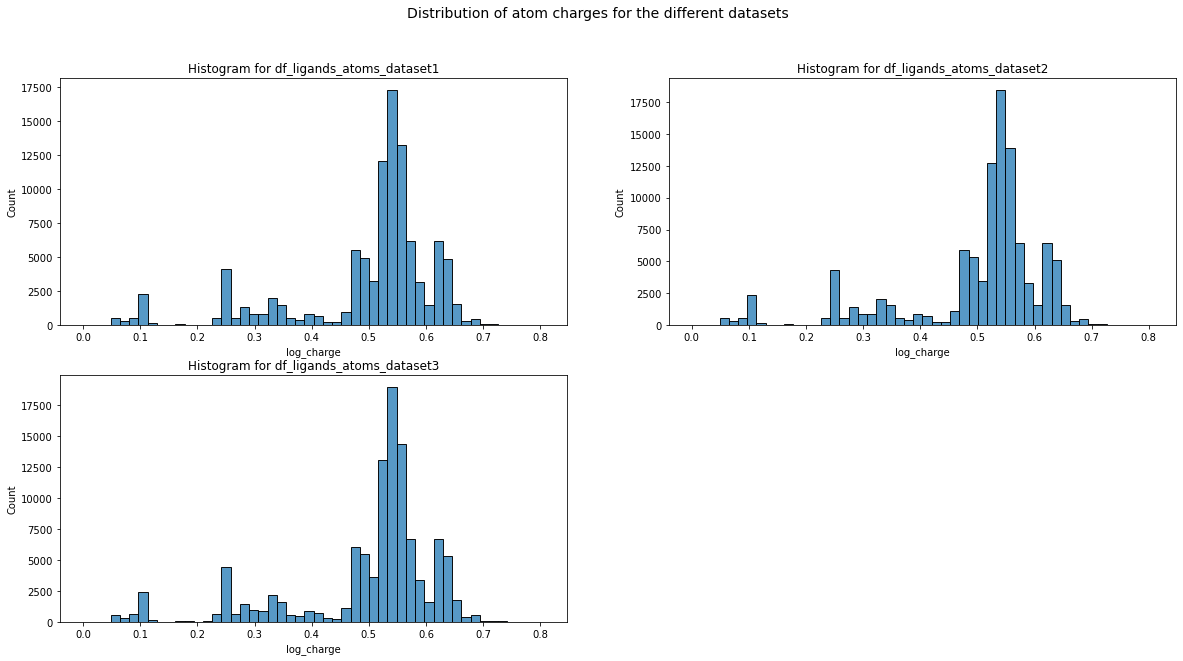

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of atom charges for the different datasets ", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_charge',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_charge',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_charge',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset3')

In [ ]:
""" Here, we want to normize the data to make it between 0 and 1 """ 
for dataset in [df_ligands_atoms_dataset1, df_ligands_atoms_dataset2, df_ligands_atoms_dataset3]:
    dataset['log_charge_normalized'] = (dataset.log_charge - dataset.log_charge.min()) / (dataset.log_charge.max() - dataset.log_charge.min())

Text(0.5, 1.0, 'Histogram for df_ligands_atoms_dataset3')

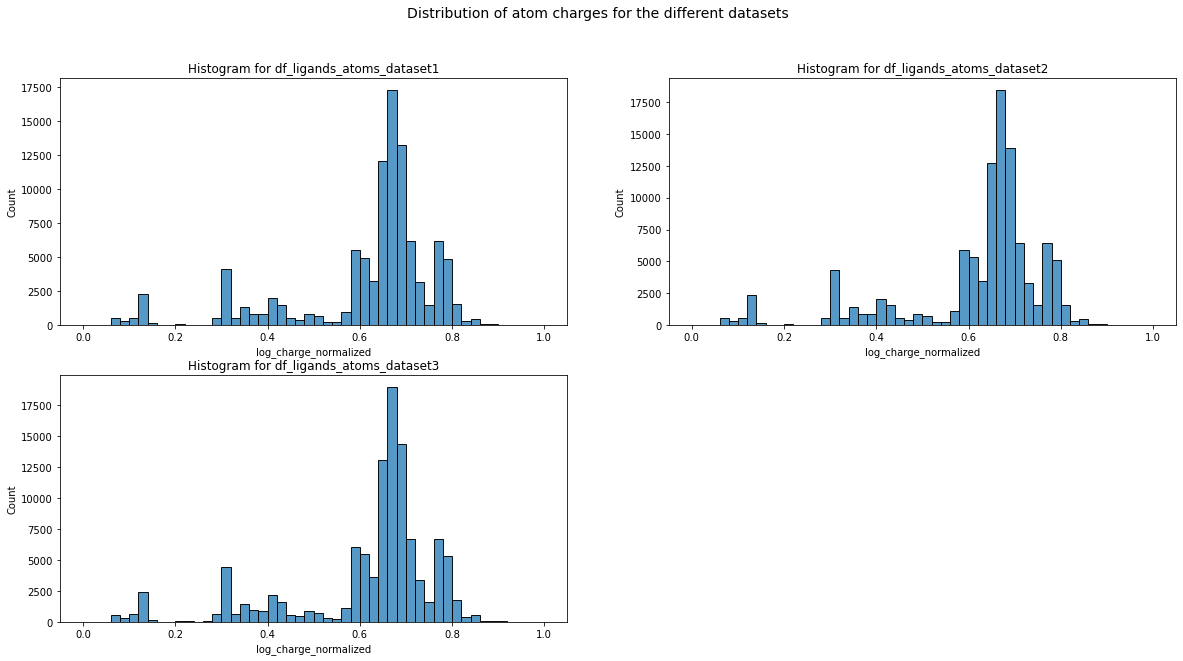

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Distribution of atom charges for the different datasets ", fontsize=14)

plt.subplot(2,2,1)
sns.histplot(data=df_ligands_atoms_dataset1,x='log_charge_normalized',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset1')

plt.subplot(2,2,2)
sns.histplot(data=df_ligands_atoms_dataset2,x='log_charge_normalized',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset2')

plt.subplot(2,2,3)
sns.histplot(data=df_ligands_atoms_dataset3,x='log_charge_normalized',bins=50)
plt.title('Histogram for df_ligands_atoms_dataset3')

In [62]:
from Bio.Seq import Seq
seq1 = Seq(df_seq_align[df_seq_align['pdb_code']=='10gs'].entry.iloc[0])
seq2 = Seq(df_seq_align[df_seq_align['pdb_code']=='10gs'].entry.iloc[1])

In [66]:
from Bio import Align 
aligner = Align.PairwiseAligner()
aligner = Align.PairwiseAligner(match_score=1.0)
aligner.score(seq1, seq2)

24.0

In [67]:
alignments = aligner.aligne(seq1,seq2)
for alignment in alignments:
    print(alignment)

AttributeError: 'PairwiseAligner' object has no attribute 'aligne'

In [52]:
seq1 = df_seq_align[df_seq_align['pdb_code']=='10gs'].entry
seq2 = df_seq_align[df_seq_align['pdb_code']=='184l'].entry
score = aligner.score(seq1,seq2)

ValueError: alphabet is None; cannot interpret sequence

In [35]:
from Bio.PDB.PDBParser import PDBParser

# You can use a dict to convert three letter code to one letter code
d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M','HOH':'Z'}

# Just an example input pdb
path = "C:/Users/redha.cherif_artefac/GitHub_perso/Research_project/Input/PDBbind_v2020_refined/1a1e/1a1e_protein.pdb"

# run parser
parser = PDBParser(PERMISSIVE=1)#,QUIET=True)
structure = parser.get_structure('test', path) 

# iterate each model, chain, and residue
# printing out the sequence for each chain
for model in structure:
     for chain in model:
        seq = []
        for residue in chain:
            seq.append(d3to1[residue.resname])
        print('>some_header\n',''.join(seq))
        print(len(chain))

>some_header
 IQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCP
104
>some_header
 IQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCP
104
>some_header
 ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ
44


c:\Users\redha.cherif_artefac\miniconda3\envs\research_project\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 1659
  warnings.warn(
c:\Users\redha.cherif_artefac\miniconda3\envs\research_project\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 3256
  warnings.warn(
c:\Users\redha.cherif_artefac\miniconda3\envs\research_project\lib\site-packages\Bio\PDB\PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3301
  warnings.warn(


In [ ]:
d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

lst = []
for element in df_seq_align.entry.values.tolist():
    for key in d3to1:
        element = element.replace(key,d3to1[key])
        element = element.replace(' ','')
    lst.append(element)

df_seq_align['entry_new'] = lst

In [ ]:
l = []
for element in df_seq_align[(df_seq_align['pdb_code']=='1ax0')&(df_seq_align['entry_new_length']==11)].entry.tolist():
    for key in d3to1:
        element = element.replace(key,d3to1[key])
        #element = element.replace(' ','')
    l.append(l)
print(l)

GLU GLN PRO TYR THR ARG PRO LEU PRO ALA ASP GLY LEU
GLU GLN PRO TYR THR ARG PRO LEU PRO ALA ASP GLY LEU


In [ ]:
length = []
for element in df_seq_align.entry.values.tolist():
    len_ = len(element.split())
    length.append(len_)

In [ ]:
df_seq_align['entry_length'] = length
df_seq_align['entry_new_length'] = [len(x) for x in df_seq_align.entry_new]

In [ ]:
df_seq_align['diff'] = df_seq_align['entry_length'] - df_seq_align['entry_new_length']

In [ ]:
df_seq_align[(df_seq_align['diff']!=0)].head()

,entry,pdb_code,entry_new,entry_length,entry_new_length,diff
1749,GLU GLN PRO TYR THR ARG PRO LEU PRO ALA ASP GL...,1ax0,EQPYWLPADGL,13,11,2
1768,GLU GLN PRO TYR THR ARG PRO LEU PRO ALA ASP GL...,1ax0,EQPYWLPADGL,13,11,2
2057,ACE MET GLU ASN PHE GLN LYS VAL GLU LYS ILE GL...,1b38,ACEMENFQKVEKIGE,13,15,-2
6663,ILE CSO GLY HIS LYS ALA ILE GLY THR VAL LEU VA...,1dmp,ICSOGHKAIGTVLVG,13,15,-2
6671,ILE CSO GLY HIS LYS ALA ILE GLY THR VAL LEU VA...,1dmp,ICSOGHKAIGTVLVG,13,15,-2


In [ ]:
d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

liste = []
for element in df_seq_align.entry.values.tolist():
    element = element.split()
    element = replace(element,d3to1)
    liste.append(element)

df_seq_align['entry_new'] = liste

In [ ]:
length = []
for element in df_seq_align.entry.values.tolist():
    len_ = len(element.split())
    length.append(len_)

In [ ]:
df_seq_align['entry_length'] = length
df_seq_align['entry_new_length'] = [len(x) for x in df_seq_align.entry_new]

In [ ]:
df_seq_align['diff'] = df_seq_align['entry_length'] - df_seq_align['entry_new_length']

In [ ]:
df_seq_align[(df_seq_align['diff']!=0)]

,entry,pdb_code,entry_new,entry_length,entry_new_length,diff


In [ ]:
new_list = []
for element in df_seq_align.entry_new.values:
    element = ''.join(element)
    new_list.append(element)

In [ ]:
df_seq_align['entry_new_v2'] = new_list

In [ ]:
df_seq_align['entry_new_v2_length'] = [len(x) for x in df_seq_align.entry_new_v2]

In [ ]:
df_seq_align['diff_v2'] = df_seq_align['entry_length'] - df_seq_align['entry_new_v2_length']

In [ ]:
""" We are taking amino acids which are not comon, hence are not in our d3to1 dictionary"""  
new_amino_acids = []
for element in df_seq_align.entry_new.values:
    for item in element:
        if len(item) > 1:
            new_amino_acids.append(item)

In [ ]:
def unique(list1):
  
    # initialize a null list
    unique_list = []
  
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)

In [ ]:
print(f"The amino acids which are not in our dictionary d3to1 are:")
unique(new_amino_acids)

The amino acids which are not in our dictionary d3to1 are:
ACE
CSO
PCA
TPO
SEP
MSE
KCX
PTR
LLP
